# Face detection and recognition training pipeline

The following example illustrates how to fine-tune an InceptionResnetV1 model on your own dataset. This will mostly follow standard pytorch training patterns.

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os

#### Define run parameters

The dataset should follow the VGGFace2/ImageNet-style directory layout. Modify `data_dir` to the location of the dataset on wish to finetune on.

In [2]:
data_dir = 'facenet_pytorch/data/CustomTrain'

batch_size = 32
epochs = 8
workers = 0 if os.name == 'nt' else 8

#### Determine if an nvidia GPU is available

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


#### Define MTCNN module

See `help(MTCNN)` for more details.

In [4]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

#### Perfom MTCNN facial detection

Iterate through the DataLoader object and obtain cropped faces.

In [5]:
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]
     

In [6]:
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]
        
loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

In [5]:


for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    
# Remove mtcnn to reduce GPU memory usage
del mtcnn

M:\AdversarialAttacks\InceptionResnet\facenet_pytorch\models\utils\detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
M:\AdversarialAttacks\InceptionResnet\facenet_pytorch\models\mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
M:\AdversarialAttacks\InceptionResnet\facenet_pytorch\models\mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarr

Batch 10 of 16

M:\AdversarialAttacks\InceptionResnet\facenet_pytorch\models\mtcnn.py:444: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  selected_boxes = np.array(selected_boxes)
M:\AdversarialAttacks\InceptionResnet\facenet_pytorch\models\mtcnn.py:446: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  selected_points = np.array(selected_points)


Batch 16 of 16

#### Define Inception Resnet V1 module

See `help(InceptionResnetV1)` for more details.

In [7]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)

In [7]:
resnet

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

#### Define optimizer, scheduler, dataset, and dataloader

In [8]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)

val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=1,
    sampler=SubsetRandomSampler(val_inds)
)

In [11]:
data = next(iter(train_loader))
data

[tensor([[[[-0.9414, -0.9492, -0.9648,  ..., -0.9102, -0.8555, -0.7930],
           [-0.9492, -0.9492, -0.9570,  ..., -0.9336, -0.8789, -0.8164],
           [-0.9414, -0.9570, -0.9648,  ..., -0.9492, -0.9023, -0.8789],
           ...,
           [ 0.7617,  0.7617,  0.7617,  ..., -0.5742, -0.5820, -0.5820],
           [ 0.7617,  0.7617,  0.7617,  ..., -0.5039, -0.5117, -0.5117],
           [ 0.7617,  0.7617,  0.7617,  ..., -0.3477, -0.3477, -0.3555]],
 
          [[-0.9336, -0.9414, -0.9492,  ..., -0.9336, -0.8867, -0.8477],
           [-0.9414, -0.9414, -0.9414,  ..., -0.9570, -0.9102, -0.8633],
           [-0.9336, -0.9414, -0.9492,  ..., -0.9570, -0.9258, -0.9023],
           ...,
           [ 0.7539,  0.7539,  0.7539,  ..., -0.5508, -0.5508, -0.5508],
           [ 0.7539,  0.7539,  0.7539,  ..., -0.4805, -0.4727, -0.4805],
           [ 0.7539,  0.7539,  0.7539,  ..., -0.3164, -0.3086, -0.3164]],
 
          [[-0.9414, -0.9414, -0.9492,  ..., -0.9336, -0.9023, -0.8555],
           [-

#### Define loss and evaluation functions

In [9]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = { 
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

## Train model

In [34]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |     3/3    | loss:    0.0005 | fps:  828.0667 | acc:    1.0000   

Epoch 1/8
----------
Train |    12/12   | loss:    0.1347 | fps:  372.3381 | acc:    0.9609   
Valid |     3/3    | loss:    0.9934 | fps: 1033.0707 | acc:    0.7771   

Epoch 2/8
----------
Train |    12/12   | loss:    0.0709 | fps:  375.0671 | acc:    0.9792   
Valid |     3/3    | loss:    1.6478 | fps: 1095.3795 | acc:    0.7028   

Epoch 3/8
----------
Train |    12/12   | loss:    0.0330 | fps:  369.5888 | acc:    0.9870   
Valid |     3/3    | loss:    0.6443 | fps: 1087.5527 | acc:    0.9146   

Epoch 4/8
----------
Train |    12/12   | loss:    0.0490 | fps:  375.0645 | acc:    0.9818   
Valid |     3/3    | loss:    0.1054 | fps: 1082.9178 | acc:    0.9688   

Epoch 5/8
----------
Train |    12/12   | loss:    0.0509 | fps:  371.2674 | acc:    0.9896   
Valid |     3/3    | loss:    0.2503 | fps: 1071.0903 | acc:    0.8729   

Epoch 6/8
----------
Train |    12/12   | loss:    0.0

In [35]:
torch.save(resnet.state_dict(), 'CustomTrained_StateDict.pth')
torch.save(resnet, "CustomTrained.pth")

## Load Model

In [10]:
resnet.load_state_dict(torch.load('CustomTrained_StateDict.pth'))

<All keys matched successfully>

# Inference

In [11]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('facenet_pytorch/data/val')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [12]:
dataset.idx_to_class

{0: 'Ishan',
 1: 'Janvi',
 2: 'Rahul',
 3: 'Rushiraj',
 4: 'Shakti',
 5: 'Tirthraj',
 6: 'Vaishvi',
 7: 'Vidhi'}

In [15]:
faces, classes = next(iter(loader))


#### Perfom MTCNN facial detection

Iterate through the DataLoader object and detect faces and associated detection probabilities for each. The `MTCNN` forward method returns images cropped to the detected face, if a face was detected. By default only a single detected face is returned - to have `MTCNN` return all detected faces, set `keep_all=True` when creating the MTCNN object above.

To obtain bounding boxes rather than cropped face images, you can instead call the lower-level `mtcnn.detect()` function. See `help(mtcnn.detect)` for details.

In [81]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [17]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

Face detected with probability: 0.999442
Face detected with probability: 0.998941
Face detected with probability: 0.999992
Face detected with probability: 1.000000
Face detected with probability: 0.999982
Face detected with probability: 0.999572
Face detected with probability: 0.999247
Face detected with probability: 0.999961
Face detected with probability: 1.000000
Face detected with probability: 0.999888
Face detected with probability: 0.999994
Face detected with probability: 0.999991
Face detected with probability: 0.999575
Face detected with probability: 0.999972
Face detected with probability: 0.999998


In [15]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

#### Print distance matrix for classes

In [22]:
import pandas as pd

dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
print(pd.DataFrame(dists, columns=names, index=names))

              Ishan      Ishan      Janvi      Janvi      Rahul      Rahul  \
Ishan      0.000000   8.014633  28.454613  26.376608  24.847273  29.141624   
Ishan      8.014633   0.000000  21.398407  19.305124  18.292225  22.724724   
Janvi     28.454613  21.398407   0.000000   2.628098  22.155165  25.325819   
Janvi     26.376608  19.305124   2.628098   0.000000  20.649338  24.118029   
Rahul     24.847273  18.292225  22.155165  20.649338   0.000000   5.599203   
Rahul     29.141624  22.724724  25.325819  24.118029   5.599203   0.000000   
Rushiraj  21.440277  15.107408  17.069206  15.482047  14.293674  18.466772   
Rushiraj  22.333164  16.277927  20.451567  19.017860  13.351108  16.843367   
Shakti    22.521097  15.777450  12.081290  10.568524  15.605370  20.492598   
Shakti    26.605022  20.893017  18.047623  17.327953  19.039120  23.629587   
Tirthraj  20.360979  15.932787  21.255812  19.433573  16.775839  21.657375   
Tirthraj  19.358259  14.579584  20.264151  18.271040  16.069973 

## DataLoader based Inference

In [17]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

Face detected with probability: 0.999442
Face detected with probability: 0.998941
Face detected with probability: 0.999992
Face detected with probability: 1.000000
Face detected with probability: 0.999982
Face detected with probability: 0.999572
Face detected with probability: 0.999247
Face detected with probability: 0.999961
Face detected with probability: 1.000000
Face detected with probability: 0.999888
Face detected with probability: 0.999994
Face detected with probability: 0.999991
Face detected with probability: 0.999574
Face detected with probability: 0.999972
Face detected with probability: 0.999998


In [18]:
#faces = faces.to(device)
faces = torch.stack(aligned).to(device)

outputs = resnet(faces)
prob, preds = torch.max(outputs, 1)
preds = preds.detach().cpu().numpy()
print([dataset.idx_to_class[p] for p in preds])

['Ishan', 'Ishan', 'Janvi', 'Janvi', 'Rahul', 'Rahul', 'Rushiraj', 'Rushiraj', 'Shakti', 'Shakti', 'Tirthraj', 'Tirthraj', 'Vaishvi', 'Vidhi', 'Vidhi']


In [19]:
#faces = faces.to(device)
faces = torch.stack(aligned).to(device)

outputs = resnet(faces)
prob, preds = torch.max(outputs, 1)
preds = preds.detach().cpu().numpy()
print(prob, preds)
print([dataset.idx_to_class[p] for p in preds])

tensor([12.9818, 15.7613, 12.4672,  7.7051, 11.4597, 12.6357,  6.0558, 14.5238,
        10.5792, 12.0445, 16.8138, 15.0823, 14.3333,  8.7751,  4.6872],
       device='cuda:0', grad_fn=<MaxBackward0>) [0 0 1 1 2 2 3 3 4 4 5 5 6 7 7]
['Ishan', 'Ishan', 'Janvi', 'Janvi', 'Rahul', 'Rahul', 'Rushiraj', 'Rushiraj', 'Shakti', 'Shakti', 'Tirthraj', 'Tirthraj', 'Vaishvi', 'Vidhi', 'Vidhi']


In [12]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

transform = A.Compose([
    ToTensorV2()
])

# Read an image with OpenCV and convert it to the RGB colorspace
image = cv2.imread("facenet_pytorch/data/val/Rushiraj/rFile586.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Augment an image
transformed = transform(image=image)
transformed_image = transformed["image"]

In [22]:
aligned = []
x_aligned, prob = mtcnn(image, return_prob=True)
aligned.append(x_aligned)

In [26]:
#faces = faces.to(device)
faces = torch.stack(aligned).to(device)

outputs = resnet(faces)
prob, preds = torch.max(outputs, 1)
preds = preds.detach().cpu().numpy() 
print(prob, preds)
print([dataset.idx_to_class[p] for p in preds])

tensor([14.4948], device='cuda:0', grad_fn=<MaxBackward0>) [3]
['Rushiraj']


# Adversarial Attacks

In [25]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    
    noise_matrix = epsilon*sign_data_grad
    torch.save(noise_matrix, "NoiseMatrix.pth")
    
    return perturbed_image

In [73]:
import torch
import numpy as np
import time


class Logger(object):

    def __init__(self, mode, length, calculate_mean=False):
        self.mode = mode
        self.length = length
        self.calculate_mean = calculate_mean
        if self.calculate_mean:
            self.fn = lambda x, i: x / (i + 1)
        else:
            self.fn = lambda x, i: x

    def __call__(self, loss, metrics, i):
        track_str = '\r{} | {:5d}/{:<5d}| '.format(self.mode, i + 1, self.length)
        loss_str = 'loss: {:9.4f} | '.format(self.fn(loss, i))
        metric_str = ' | '.join('{}: {:9.4f}'.format(k, self.fn(v, i)) for k, v in metrics.items())
        print(track_str + loss_str + metric_str + '   ', end='')
        if i + 1 == self.length:
            print('')


class BatchTimer(object):
    """Batch timing class.
    Use this class for tracking training and testing time/rate per batch or per sample.
    
    Keyword Arguments:
        rate {bool} -- Whether to report a rate (batches or samples per second) or a time (seconds
            per batch or sample). (default: {True})
        per_sample {bool} -- Whether to report times or rates per sample or per batch.
            (default: {True})
    """

    def __init__(self, rate=True, per_sample=True):
        self.start = time.time()
        self.end = None
        self.rate = rate
        self.per_sample = per_sample

    def __call__(self, y_pred, y):
        self.end = time.time()
        elapsed = self.end - self.start
        self.start = self.end
        self.end = None

        if self.per_sample:
            elapsed /= len(y_pred)
        if self.rate:
            elapsed = 1 / elapsed

        return torch.tensor(elapsed)


def accuracy(logits, y):
    _, preds = torch.max(logits, 1)
    return (preds == y).float().mean()

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad, eps_value):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    
    noise_matrix = epsilon*sign_data_grad
    #torch.save(noise_matrix, "NoiseMatrix_{0}.pth".format(eps_value))
    return perturbed_image, noise_matrix



# noise_matrix = epsilon*sign_data_grad

# face countours + noise_matrix[contour_area]

# How do we extract contours from the tensor??

# tensor - PIL Image - extract Pixels 



def pass_epoch(
    model, epsilon, loss_fn, loader, optimizer=None, scheduler=None,
    batch_metrics={'time': BatchTimer()}, show_running=True,
    device='cpu', writer=None
):
    
    mode = 'Train' if model.training else 'Valid'
    logger = Logger(mode, length=len(loader), calculate_mean=show_running)
    loss = 0
    metrics = {}
    
    epsilon_value = epsilon
    final_matrix = torch.zeros(1, 3, 160, 160, device = 'cuda:0') # IMAGE SIZE 160 , Add Noise of ever Image in the DataLoader

    correct = 0
    adv_examples = []
    
    
    for i_batch, (X, y) in enumerate(loader):
        X = X.to(device)
        y = y.to(device)
        
        X.requires_grad = True
        
        y_pred = model(X)
        loss_batch = loss_fn(y_pred, y)

        init_pred = y_pred.max(1, keepdim=True)[1] # get the index of the max log-probability
        

        #If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != y.item():
            print("INSIDE")
            print(init_pred, y)
            continue
        
        model.zero_grad()
        loss_batch.backward()
        
        data_grad = X.grad.data

        # Call FGSM Attack
        perturbed_data, noise_matrix = fgsm_attack(X, epsilon, data_grad, epsilon_value)
        output = model(perturbed_data)
        
        
         # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        final_matrix = final_matrix + noise_matrix
        
        
        if final_pred.item() == y.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

        # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(loader), final_acc))

    torch.save(final_matrix, "NoiseMatrix_{0}.pth".format(epsilon_value))
    return final_acc, adv_examples


def collate_pil(x): 
    out_x, out_y = [], [] 
    for xx, yy in x: 
        out_x.append(xx) 
        out_y.append(yy) 
    return out_x, out_y 


In [74]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

accuracies = []
examples = []

epsilons = [0.05, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 2, 3, 4]

resnet.eval()

# Run test for each epsilon
for eps in epsilons:
    acc, ex =  pass_epoch(
        resnet, eps, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    accuracies.append(acc)
    examples.append(ex)
    
writer.close()

Epsilon: 0.05	Test Accuracy = 10 / 94 = 0.10638297872340426
Epsilon: 0.1	Test Accuracy = 10 / 94 = 0.10638297872340426
Epsilon: 0.2	Test Accuracy = 31 / 94 = 0.32978723404255317
Epsilon: 0.3	Test Accuracy = 22 / 94 = 0.23404255319148937
Epsilon: 0.4	Test Accuracy = 18 / 94 = 0.19148936170212766
Epsilon: 0.5	Test Accuracy = 18 / 94 = 0.19148936170212766
Epsilon: 0.6	Test Accuracy = 18 / 94 = 0.19148936170212766
Epsilon: 0.7	Test Accuracy = 17 / 94 = 0.18085106382978725
Epsilon: 0.8	Test Accuracy = 11 / 94 = 0.11702127659574468
Epsilon: 0.9	Test Accuracy = 7 / 94 = 0.07446808510638298
Epsilon: 1.0	Test Accuracy = 7 / 94 = 0.07446808510638298
Epsilon: 2	Test Accuracy = 10 / 94 = 0.10638297872340426
Epsilon: 3	Test Accuracy = 10 / 94 = 0.10638297872340426
Epsilon: 4	Test Accuracy = 10 / 94 = 0.10638297872340426


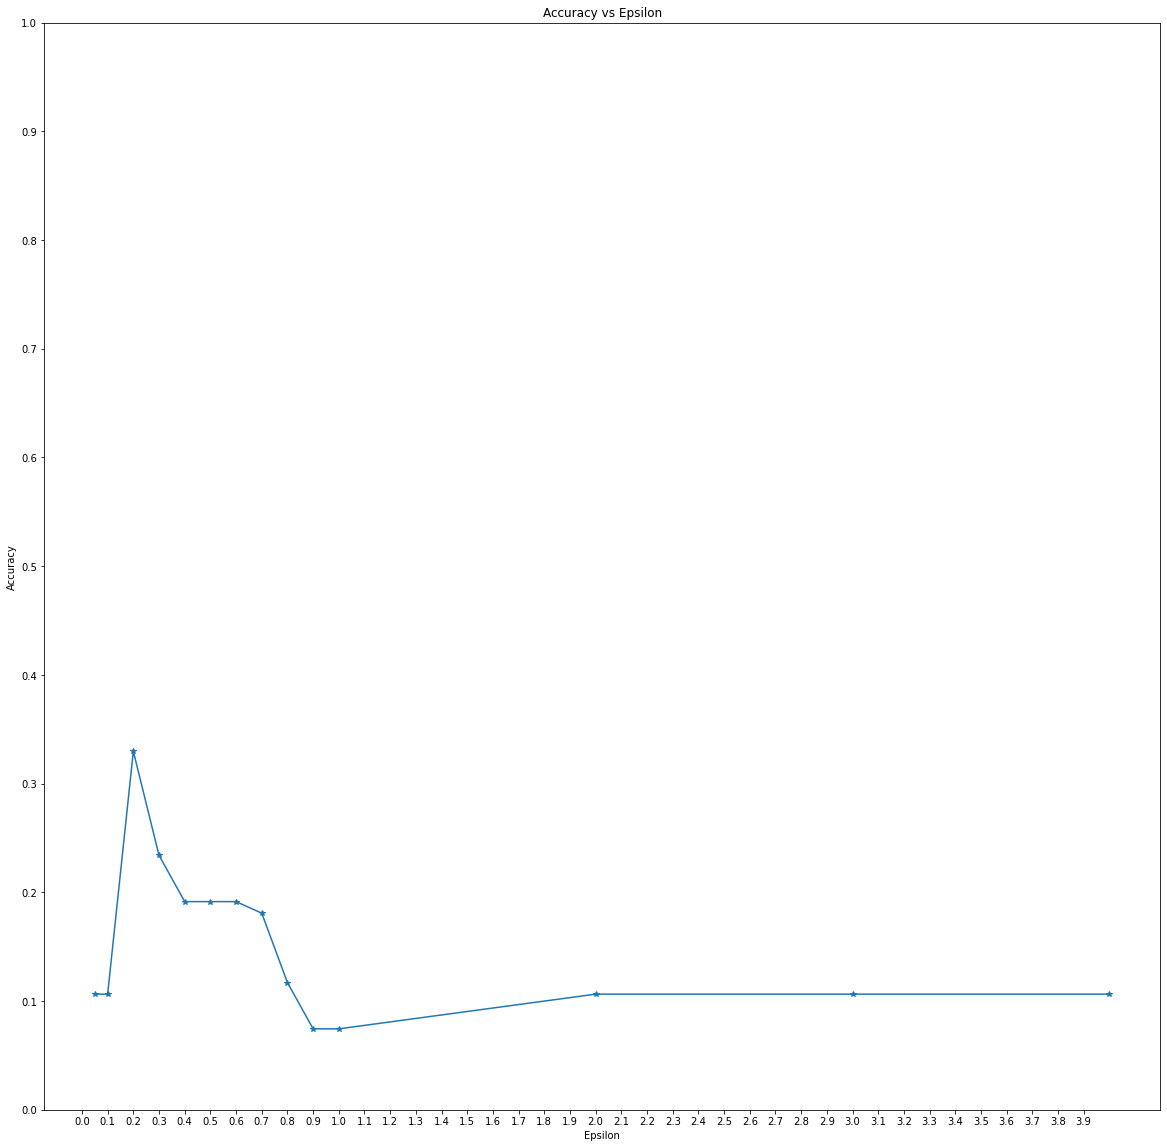

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
plt.plot(epsilons, accuracies, "*-")

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 4, step=0.1))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.savefig("TrainChart.png", dpi = 100, facecolor = 'white')
plt.show()

# Iterative Noise Addition

In [13]:
import torch
import numpy as np
import time
import random

class Logger(object):

    def __init__(self, mode, length, calculate_mean=False):
        self.mode = mode
        self.length = length
        self.calculate_mean = calculate_mean
        if self.calculate_mean:
            self.fn = lambda x, i: x / (i + 1)
        else:
            self.fn = lambda x, i: x

    def __call__(self, loss, metrics, i):
        track_str = '\r{} | {:5d}/{:<5d}| '.format(self.mode, i + 1, self.length)
        loss_str = 'loss: {:9.4f} | '.format(self.fn(loss, i))
        metric_str = ' | '.join('{}: {:9.4f}'.format(k, self.fn(v, i)) for k, v in metrics.items())
        print(track_str + loss_str + metric_str + '   ', end='')
        if i + 1 == self.length:
            print('')


class BatchTimer(object):
    """Batch timing class.
    Use this class for tracking training and testing time/rate per batch or per sample.
    
    Keyword Arguments:
        rate {bool} -- Whether to report a rate (batches or samples per second) or a time (seconds
            per batch or sample). (default: {True})
        per_sample {bool} -- Whether to report times or rates per sample or per batch.
            (default: {True})
    """

    def __init__(self, rate=True, per_sample=True):
        self.start = time.time()
        self.end = None
        self.rate = rate
        self.per_sample = per_sample

    def __call__(self, y_pred, y):
        self.end = time.time()
        elapsed = self.end - self.start
        self.start = self.end
        self.end = None

        if self.per_sample:
            elapsed /= len(y_pred)
        if self.rate:
            elapsed = 1 / elapsed

        return torch.tensor(elapsed)


In [15]:
def accuracy(logits, y):
    _, preds = torch.max(logits, 1)
    return (preds == y).float().mean()

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    
    noise_matrix = epsilon*sign_data_grad
    #torch.save(noise_matrix, "NoiseMatrix_{0}.pth".format(eps_value))
    return perturbed_image, noise_matrix



# noise_matrix = epsilon*sign_data_grad

# face countours + noise_matrix[contour_area]

# How do we extract contours from the tensor??

# tensor - PIL Image - extract Pixels 



def pass_epoch(
    model, loss_fn, loader, optimizer=None, scheduler=None,
    batch_metrics={'time': BatchTimer()}, show_running=True,
    device='cpu', writer=None
):
    
    mode = 'Train' if model.training else 'Valid'
    logger = Logger(mode, length=len(loader), calculate_mean=show_running)
    loss = 0
    metrics = {}
    
    epsilon_value = 3
    final_matrix = torch.zeros(1, 3, 160, 160, device = 'cuda:0') # IMAGE SIZE 160 , Add Noise of ever Image in the DataLoader

    correct = 0
    adv_examples = []
    epsilons = []
    
    
    for i_batch, (X, y) in enumerate(loader):
        X = X.to(device)
        y = y.to(device)
        
        X.requires_grad = True
        
        y_pred = model(X)
        loss_batch = loss_fn(y_pred, y)

        init_pred = y_pred.max(1, keepdim=True)[1] # get the index of the max log-probability
        

        #If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != y.item():
            print("INSIDE")
            print(init_pred, y)
            continue
        
        model.zero_grad()
        loss_batch.backward()
        
        data_grad = X.grad.data 
        
        # Call FGSM Attack
        perturbed_data_orig, noise_matrix = fgsm_attack(X, epsilon_value, data_grad)
        output = model(perturbed_data_orig)
        
        
         # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        #final_matrix = final_matrix + noise_matrix
        
        if final_pred.item() == y.item():
            print("Image No - ", i_batch)
            while final_pred.item() == y.item():

                #epsilon_value = epsilon_value + 1
                perturbed_data, noise_matrix = fgsm_attack(X, epsilon_value, data_grad)
                
                added_perturbed_data = perturbed_data + perturbed_data_orig
                
                output = model(added_perturbed_data)
                
                perturbed_data_orig = added_perturbed_data

                 # Check for success
                final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

                #final_matrix = final_matrix + noise_matrix
                epsilons.append(epsilon_value)
                print(epsilon_value, final_pred.item(), y.item())

        elif final_pred.item() == y.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            final_matrix = final_matrix + noise_matrix
            
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
                epsilons.append(epsilon_value)

        # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon_value, correct, len(loader), final_acc))
    
    #torch.save(final_matrix, "NoiseMatrix_{0}.pth".format(epsilon_value))
    return final_acc, adv_examples, epsilons


def collate_pil(x): 
    out_x, out_y = [], [] 
    for xx, yy in x: 
        out_x.append(xx) 
        out_y.append(yy) 
    return out_x, out_y 


### On Patches

# Testing the Patch and Noise Addition Loop

In [6]:
import cv2
frame = cv2.imread("M:/AdversarialAttacks/effect_1/rushi.jpg")
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
trans = transforms.Compose([transforms.ToTensor()])
test_tensor = trans(frame)
test_tensor = test_tensor.unsqueeze(0).cuda()
test_tensor.shape

torch.Size([1, 3, 112, 112])

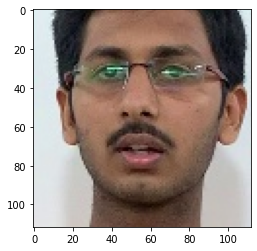

In [17]:
import matplotlib.pyplot as plt
import torchvision.utils as utils
plt.imshow(np.transpose(utils.make_grid(test_tensor.detach().cpu(), padding=2, normalize=True),(1,2,0)))

In [7]:
noise_matrix = torch.load('NoiseMatrices/NoiseMatrix_3.pth')
# noise_matrix=noise_matrix.squeeze(0)
# noise_matrix.shape

In [8]:
bd_image = cv2.imread("M:/AdversarialAttacks/effect_1/BD.jpeg")
bd_image = cv2.cvtColor(bd_image, cv2.COLOR_BGR2RGB)

from torchvision import transforms
trans = transforms.Compose([transforms.ToTensor()])

In [3]:

import dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("M:/AdversarialAttacks/effect_1/shape_predictor_68_face_landmarks.dat")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


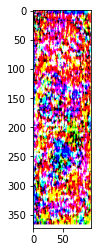

In [59]:
import matplotlib.pyplot as plt

np_img = noise_matrix[0].detach().cpu().numpy()
np_img = np.transpose(np_img, (1,2,0))

np_img = cv2.resize(np_img, (bd_image.shape[1], bd_image.shape[0]))

np_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB)

noisy_patch = bd_image + bd_image * np_img

rows, cols, _ = noisy_patch.shape
nose_mask = np.zeros((rows, cols), np.uint8)

nose_mask.fill(0)

plt.imshow(noisy_patch)

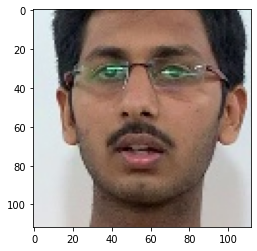

In [42]:

frame = test_tensor[0].detach().cpu().numpy()
frame = np.transpose(frame, (1,2,0))
frame = cv2.normalize(src=frame, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) ## V.V.IMP!!
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
# gray_frame = gray_frame.astype(np.int8)
plt.imshow(frame)

In [93]:
from math import hypot

faces = detector(frame)

for face in faces:
    landmarks = predictor(gray_frame, face)

    top_nose = (landmarks.part(27).x, landmarks.part(27).y)
    center_nose = (landmarks.part(29).x, landmarks.part(29).y)

    left_eye_point = (landmarks.part(39).x, landmarks.part(39).y)
    right_eye_point = (landmarks.part(42).x, landmarks.part(42).y)

    nose_width = int(hypot(left_eye_point[0] - right_eye_point[0],
                            left_eye_point[1] - right_eye_point[1]))

    nose_height = int(nose_width * 1.73)   # 0.37 comes from H/W of the Image (373/100) - 1.73 is a random no

    # New nose position
    top_left = (int(center_nose[0] - nose_width / 2),
                    int(center_nose[1] - nose_height /2))

    bottom_right = (int(center_nose[0] + nose_width / 2),
                        int(center_nose[1] + nose_height / 2))

    # Adding the Band Aid Image
    bd_pic = cv2.resize(noisy_patch, (nose_width, nose_height))
    bd_pic_gray = cv2.cvtColor(bd_pic, cv2.COLOR_BGR2GRAY)
    _, nose_mask = cv2.threshold(bd_pic_gray, 25, 255, cv2.THRESH_BINARY_INV)

    nose_area = frame[top_left[1]: top_left[1] + nose_height,
                top_left[0]: top_left[0] + nose_width]

    nose_mask = nose_mask.astype(np.uint8)
    
    nose_area_no_nose = cv2.bitwise_and(nose_area, nose_area, mask=nose_mask)
    
    bd_pic = bd_pic.astype(np.uint8)
    final_nose = cv2.add(nose_area_no_nose, bd_pic)
    final_nose = cv2.cvtColor(final_nose, cv2.COLOR_BGR2RGB)
    #print("Final Nose Shape", final_nose.shape)

    frame[top_left[1]: top_left[1] + nose_height,
                top_left[0]: top_left[0] + nose_width] = final_nose

image = trans(frame)
#image = image.unsqueeze(0).cuda()

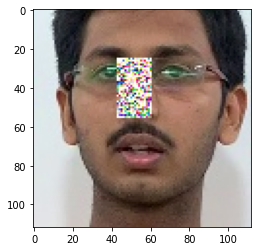

In [67]:
import torchvision.utils as utils
plt.imshow(np.transpose(utils.make_grid(image.detach().cpu(), padding=2, normalize=True),(1,2,0)))

In [ ]:
resnet.eval()              # REQUIRED for Inference or else you will get the BatchNorm 1 channel error

#faces = faces.to(device)
faces = torch.stack(aligned).to(device)

outputs = resnet(faces)
prob, preds = torch.max(outputs, 1)
preds = preds.detach().cpu().numpy() 
print(prob, preds)
print([dataset.idx_to_class[p] for p in preds])

In [34]:
from torchvision import transforms

test = cv2.imread("Nose.png")
print(test.shape)
trans = transforms.Compose([transforms.ToTensor()])

test_tensor = trans(test)
test_tensor.dtype

(112, 112, 3)


torch.float32

In [25]:
test_tensor = test_tensor.unsqueeze(0)
test_tensor.shape

torch.Size([1, 3, 112, 112])

# Run the Experiment

In [145]:
def accuracy(logits, y):
    _, preds = torch.max(logits, 1)
    return (preds == y).float().mean()

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    
    noise_matrix = epsilon*sign_data_grad
    #torch.save(noise_matrix, "NoiseMatrix_{0}.pth".format(eps_value))
    return perturbed_image, noise_matrix


# noise_matrix = epsilon*sign_data_grad

# face countours + noise_matrix[contour_area]

# How do we extract contours from the tensor??

# tensor - PIL Image - extract Pixels 



def pass_epoch(
    model, eps, loss_fn, loader, optimizer=None, scheduler=None,
    batch_metrics={'time': BatchTimer()}, show_running=True,
    device='cpu', writer=None
):
    
    mode = 'Train' if model.training else 'Valid'
    logger = Logger(mode, length=len(loader), calculate_mean=show_running)
    loss = 0
    metrics = {}
    
    epsilon_value = eps
    #final_matrix = torch.zeros(1, 3, 160, 160, device = 'cuda:0') # IMAGE SIZE 160 , Add Noise of ever Image in the DataLoader

    correct = 0
    num_fooled = 0
    adv_examples = []
    epsilons = []
    
    bd_image = cv2.imread("M:/AdversarialAttacks/effect_1/BD.jpeg")
    bd_image = cv2.cvtColor(bd_image, cv2.COLOR_BGR2RGB)

    from torchvision import transforms
    trans = transforms.Compose([transforms.ToTensor()])
    
    import dlib
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("M:/AdversarialAttacks/effect_1/shape_predictor_68_face_landmarks.dat")
    
    loop_count = 0
    
    for i_batch, (X, y) in enumerate(loader):
        X = X.to(device)
        y = y.to(device)
        
        X.requires_grad = True
        
        y_pred = model(X)
        loss_batch = loss_fn(y_pred, y)

        init_pred = y_pred.max(1, keepdim=True)[1] # get the index of the max log-probability
        

        #If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != y.item():
            print("INSIDE")
            print(init_pred, y)
            continue
        
        model.zero_grad()
        loss_batch.backward()
        
        data_grad = X.grad.data 
        
        perturbed_data, noise_matrix_orig = fgsm_attack(X, epsilon_value, data_grad)
                
        np_img = noise_matrix_orig[0].detach().cpu().numpy()
        np_img = np.transpose(np_img, (1,2,0))

        np_img = cv2.resize(np_img, (bd_image.shape[1], bd_image.shape[0]))

        np_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB)

        noisy_patch = bd_image + bd_image * np_img

        rows, cols, _ = noisy_patch.shape
        nose_mask = np.zeros((rows, cols), np.uint8)

        nose_mask.fill(0)
        
        frame = X[0].detach().cpu().numpy()
        frame = np.transpose(frame, (1,2,0))
        frame = cv2.normalize(src=frame, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) ## V.V.IMP!!
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        faces = detector(frame)

        for face in faces:
            landmarks = predictor(gray_frame, face)

            top_nose = (landmarks.part(27).x, landmarks.part(27).y)
            center_nose = (landmarks.part(29).x, landmarks.part(29).y)

            left_eye_point = (landmarks.part(39).x, landmarks.part(39).y)
            right_eye_point = (landmarks.part(42).x, landmarks.part(42).y)

            nose_width = int(hypot(left_eye_point[0] - right_eye_point[0],
                                    left_eye_point[1] - right_eye_point[1]))

            nose_height = int(nose_width * 1.73)   # 0.37 comes from H/W of the Image (373/100) - 1.73 is a random no

            # New nose position
            top_left = (int(center_nose[0] - nose_width / 2),
                            int(center_nose[1] - nose_height /2))

            bottom_right = (int(center_nose[0] + nose_width / 2),
                                int(center_nose[1] + nose_height / 2))

            # Adding the Band Aid Image
            bd_pic = cv2.resize(noisy_patch, (nose_width, nose_height))
            bd_pic_gray = cv2.cvtColor(bd_pic, cv2.COLOR_BGR2GRAY)
            _, nose_mask = cv2.threshold(bd_pic_gray, 25, 255, cv2.THRESH_BINARY_INV)

            nose_area = frame[top_left[1]: top_left[1] + nose_height,
                        top_left[0]: top_left[0] + nose_width]

            nose_mask = nose_mask.astype(np.uint8)

            nose_area_no_nose = cv2.bitwise_and(nose_area, nose_area, mask=nose_mask)

            bd_pic = bd_pic.astype(np.uint8)
            final_nose = cv2.add(nose_area_no_nose, bd_pic)
            final_nose = cv2.cvtColor(final_nose, cv2.COLOR_BGR2RGB)
            #print("Final Nose Shape", final_nose.shape)

            frame[top_left[1]: top_left[1] + nose_height,
                        top_left[0]: top_left[0] + nose_width] = final_nose
            
        image = trans(frame)
        image = image.unsqueeze(0).cuda()
        
        output = model(image)
        
        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        #final_matrix = final_matrix + noise_matrix
        
        if final_pred.item() == y.item():
            print("Image No - ", i_batch)
            
            for i in range(20):
                             
                perturbed_data, noise_matrix = fgsm_attack(X, epsilon_value, data_grad)

                added_noise_matrix = noise_matrix + noise_matrix_orig
                
                noise_matrix_orig = added_noise_matrix

            np_img = added_noise_matrix[0].detach().cpu().numpy()
            np_img = np.transpose(np_img, (1,2,0))

            np_img = cv2.resize(np_img, (bd_image.shape[1], bd_image.shape[0]))

            np_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB)

            noisy_patch = bd_image + bd_image * np_img

            rows, cols, _ = noisy_patch.shape
            nose_mask = np.zeros((rows, cols), np.uint8)

            nose_mask.fill(0)

            faces = detector(frame)

            for face in faces:
                landmarks = predictor(gray_frame, face)

                top_nose = (landmarks.part(27).x, landmarks.part(27).y)
                center_nose = (landmarks.part(29).x, landmarks.part(29).y)

                left_eye_point = (landmarks.part(39).x, landmarks.part(39).y)
                right_eye_point = (landmarks.part(42).x, landmarks.part(42).y)

                nose_width = int(hypot(left_eye_point[0] - right_eye_point[0],
                                        left_eye_point[1] - right_eye_point[1]))

                nose_height = int(nose_width * 1.73)   # 0.37 comes from H/W of the Image (373/100) - 1.73 is a random no

                # New nose position
                top_left = (int(center_nose[0] - nose_width / 2),
                                int(center_nose[1] - nose_height /2))

                bottom_right = (int(center_nose[0] + nose_width / 2),
                                    int(center_nose[1] + nose_height / 2))

                # Adding the Band Aid Image
                bd_pic = cv2.resize(bd_image, (nose_width, nose_height))
                bd_pic_gray = cv2.cvtColor(bd_pic, cv2.COLOR_BGR2GRAY)
                _, nose_mask = cv2.threshold(bd_pic_gray, 25, 255, cv2.THRESH_BINARY_INV)

                nose_area = frame[top_left[1]: top_left[1] + nose_height,
                            top_left[0]: top_left[0] + nose_width]

                nose_area_no_nose = cv2.bitwise_and(nose_area, nose_area, mask=nose_mask)

                final_nose = cv2.add(nose_area_no_nose, bd_pic)
                #print("Final Nose Shape", final_nose.shape)

                frame[top_left[1]: top_left[1] + nose_height,
                            top_left[0]: top_left[0] + nose_width] = final_nose

            image = trans(frame)
            image = image.unsqueeze(0).cuda()

            output = model(image)

             # Check for success
            final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

            #final_matrix = final_matrix + noise_matrix
            print(epsilon_value, final_pred.item(), y.item())
            epsilons.append(epsilon_value)
                

        else:
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon_value == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
                
        if final_pred.item() != y.item():
            
            num_fooled += 1
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
                #epsilons.append(epsilon_value)

        # Calculate final accuracy for this epsilon
    #final_acc = correct/float(len(loader))
    fool_rate = num_fooled/float(len(loader))
    print("Epsilon: {}\tFool Rate = {} / {} = {}".format(epsilon_value, num_fooled, len(loader), fool_rate))
    
    #torch.save(final_matrix, "NoiseMatrix_{0}.pth".format(epsilon_value))
    return fool_rate, adv_examples, epsilon_value


def collate_pil(x): 
    out_x, out_y = [], [] 
    for xx, yy in x: 
        out_x.append(xx) 
        out_y.append(yy) 
    return out_x, out_y 


In [137]:
%%time

writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

fool_rates = []
examples = []
epsilons = []

#epsilons = [0.05, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 2, 3, 4]

resnet.eval()

# Run test for each epsilon
for i in range(0,1):
    fool_rate, ex, eps_value =  pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    fool_rates.append(fool_rate)
    examples.append(ex)
    epsilons.append(eps_value)
    
writer.close()

Image No -  1
4 6 6
Image No -  5
4 6 6
Image No -  7
4 6 6
Image No -  11
4 6 6
Image No -  22
4 6 6
Image No -  31
4 6 6
Image No -  49
4 6 6
Image No -  56
4 6 6
Image No -  73
4 6 6
Image No -  93
4 0 0
Epsilon: 4	Fool Rate = 84 / 94 = 0.8936170212765957
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Wall time: 8.3 s


In [146]:
%%time

writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

fool_rates = []
examples = []
epsilons = []

epsilons = [0.05, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1, 2, 3, 4]

resnet.eval()

# Run test for each epsilon
for eps in epsilons:
    fool_rate, ex, eps_value =  pass_epoch(
        resnet, eps, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    fool_rates.append(fool_rate)
    examples.append(ex)
    epsilons.append(eps_value)
    
writer.close()

Image No -  4
0.05 6 6
Image No -  7
0.05 6 6
Image No -  12
0.05 6 6
Image No -  17
0.05 6 6
Image No -  25
0.05 6 6
Image No -  33
0.05 0 0
Image No -  38
0.05 6 6
Image No -  49
0.05 6 6
Image No -  69
0.05 6 6
Image No -  87
0.05 6 6
Epsilon: 0.05	Fool Rate = 84 / 94 = 0.8936170212765957
Image No -  1
0.1 6 6
Image No -  8
0.1 6 6
Image No -  41
0.1 6 6
Image No -  42
0.1 6 6
Image No -  59
0.1 6 6
Image No -  68
0.1 6 6
Image No -  76
0.1 6 6
Image No -  79
0.1 6 6
Image No -  91
0.1 6 6
Image No -  92
0.1 0 0
Epsilon: 0.1	Fool Rate = 84 / 94 = 0.8936170212765957
Image No -  0
0.2 6 6
Image No -  15
0.2 6 6
Image No -  29
0.2 6 6
Image No -  30
0.2 6 6
Image No -  32
0.2 6 6
Image No -  38
0.2 6 6
Image No -  56
0.2 6 6
Image No -  66
0.2 6 6
Image No -  69
0.2 0 0
Image No -  79
0.2 6 6
Epsilon: 0.2	Fool Rate = 84 / 94 = 0.8936170212765957
Image No -  11
0.3 6 6
Image No -  14
0.3 6 6
Image No -  39
0.3 6 6
Image No -  45
0.3 6 6
Image No -  49
0.3 6 6
Image No -  58
0.3 6 6
Imag

Image No -  17
0.1 6 6
Image No -  20
0.1 6 6
Image No -  29
0.1 6 6
Image No -  39
0.1 6 6
Image No -  40
0.1 0 0
Image No -  41
0.1 6 6
Image No -  56
0.1 6 6
Image No -  81
0.1 6 6
Image No -  82
0.1 6 6
Image No -  89
0.1 6 6
Epsilon: 0.1	Fool Rate = 84 / 94 = 0.8936170212765957
Image No -  5
0.2 6 6
Image No -  7
0.2 6 6
Image No -  8
0.2 0 0
Image No -  16
0.2 6 6
Image No -  24
0.2 6 6
Image No -  26
0.2 6 6
Image No -  67
0.2 6 6
Image No -  77
0.2 6 6
Image No -  85
0.2 6 6
Image No -  87
0.2 6 6
Epsilon: 0.2	Fool Rate = 84 / 94 = 0.8936170212765957
Image No -  5
0.3 6 6
Image No -  20
0.3 0 0
Image No -  30
0.3 6 6
Image No -  31
0.3 6 6
Image No -  53
0.3 6 6
Image No -  54
0.3 6 6
Image No -  58
0.3 6 6
Image No -  70
0.3 6 6
Image No -  78
0.3 6 6
Image No -  92
0.3 6 6
Epsilon: 0.3	Fool Rate = 84 / 94 = 0.8936170212765957
Image No -  1
0.4 6 6
Image No -  3
0.4 6 6
Image No -  10
0.4 6 6
Image No -  24
0.4 0 0
Image No -  48
0.4 6 6
Image No -  49
0.4 6 6
Image No -  59
0

Image No -  21
0.2 6 6
Image No -  30
0.2 6 6
Image No -  39
0.2 6 6
Image No -  45
0.2 6 6
Image No -  55
0.2 6 6
Image No -  58
0.2 0 0
Image No -  74
0.2 6 6
Image No -  76
0.2 6 6
Image No -  81
0.2 6 6
Epsilon: 0.2	Fool Rate = 84 / 94 = 0.8936170212765957
Image No -  10
0.3 6 6
Image No -  12
0.3 6 6
Image No -  17
0.3 6 6
Image No -  20
0.3 6 6
Image No -  30
0.3 6 6
Image No -  32
0.3 6 6
Image No -  38
0.3 6 6
Image No -  55
0.3 0 0
Image No -  64
0.3 6 6
Image No -  76
0.3 6 6
Epsilon: 0.3	Fool Rate = 84 / 94 = 0.8936170212765957
Image No -  1
0.4 0 0
Image No -  4
0.4 6 6
Image No -  47
0.4 6 6
Image No -  55
0.4 6 6
Image No -  65
0.4 6 6
Image No -  68
0.4 6 6
Image No -  71
0.4 6 6
Image No -  73
0.4 6 6
Image No -  86
0.4 6 6
Image No -  91
0.4 6 6
Epsilon: 0.4	Fool Rate = 84 / 94 = 0.8936170212765957
Image No -  5
0.5 0 0
Image No -  6
0.5 6 6
Image No -  12
0.5 6 6
Image No -  25
0.5 6 6
Image No -  27
0.5 6 6
Image No -  32
0.5 6 6
Image No -  71
0.5 6 6
Image No -  72

Image No -  36
0.3 6 6
Image No -  41
0.3 6 6
Image No -  46
0.3 6 6
Image No -  49
0.3 6 6
Image No -  55
0.3 0 0
Image No -  78
0.3 6 6
Image No -  93
0.3 6 6
Epsilon: 0.3	Fool Rate = 84 / 94 = 0.8936170212765957
Image No -  7
0.4 6 6
Image No -  17
0.4 6 6
Image No -  19
0.4 6 6
Image No -  23
0.4 0 0
Image No -  29
0.4 6 6
Image No -  37
0.4 6 6
Image No -  50
0.4 6 6
Image No -  68
0.4 6 6
Image No -  82
0.4 6 6
Image No -  90
0.4 6 6
Epsilon: 0.4	Fool Rate = 84 / 94 = 0.8936170212765957
Image No -  4
0.5 6 6
Image No -  16
0.5 6 6
Image No -  28
0.5 6 6
Image No -  38
0.5 0 0
Image No -  40
0.5 6 6
Image No -  43
0.5 6 6
Image No -  45
0.5 6 6
Image No -  51
0.5 0 0
Image No -  87
0.5 6 6
Image No -  88
0.5 6 6
Image No -  93
0.5 6 6
Epsilon: 0.5	Fool Rate = 83 / 94 = 0.8829787234042553
Image No -  0
0.6 6 6
Image No -  5
0.6 6 6
Image No -  14
0.6 0 0
Image No -  17
0.6 6 6
Image No -  24
0.6 6 6
Image No -  38
0.6 6 6
Image No -  48
0.6 6 6
Image No -  49
0.6 6 6
Image No -  63

Image No -  52
0.4 6 6
Image No -  57
0.4 6 6
Image No -  66
0.4 6 6
Image No -  67
0.4 0 0
Image No -  85
0.4 6 6
Image No -  92
0.4 6 6
Epsilon: 0.4	Fool Rate = 84 / 94 = 0.8936170212765957
Image No -  3
0.5 6 6
Image No -  21
0.5 6 6
Image No -  23
0.5 6 6
Image No -  34
0.5 6 6
Image No -  38
0.5 6 6
Image No -  46
0.5 6 6
Image No -  64
0.5 6 6
Image No -  68
0.5 0 0
Image No -  74
0.5 0 0
Image No -  76
0.5 6 6
Image No -  86
0.5 6 6
Epsilon: 0.5	Fool Rate = 83 / 94 = 0.8829787234042553
Image No -  3
0.6 6 6
Image No -  6
0.6 0 0
Image No -  15
0.6 6 6
Image No -  16
0.6 0 0
Image No -  29
0.6 6 6
Image No -  35
0.6 6 6
Image No -  42
0.6 6 6
Image No -  75
0.6 6 6
Image No -  76
0.6 6 6
Image No -  80
0.6 6 6
Image No -  93
0.6 6 6
Epsilon: 0.6	Fool Rate = 83 / 94 = 0.8829787234042553
Image No -  4
0.7 6 6
Image No -  6
0.7 6 6
Image No -  22
0.7 6 6
Image No -  62
0.7 6 6
Image No -  67
0.7 6 6
Image No -  68
0.7 6 6
Image No -  70
0.7 6 6
Image No -  74
0.7 0 0
Image No -  76


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (36,) and (22,)

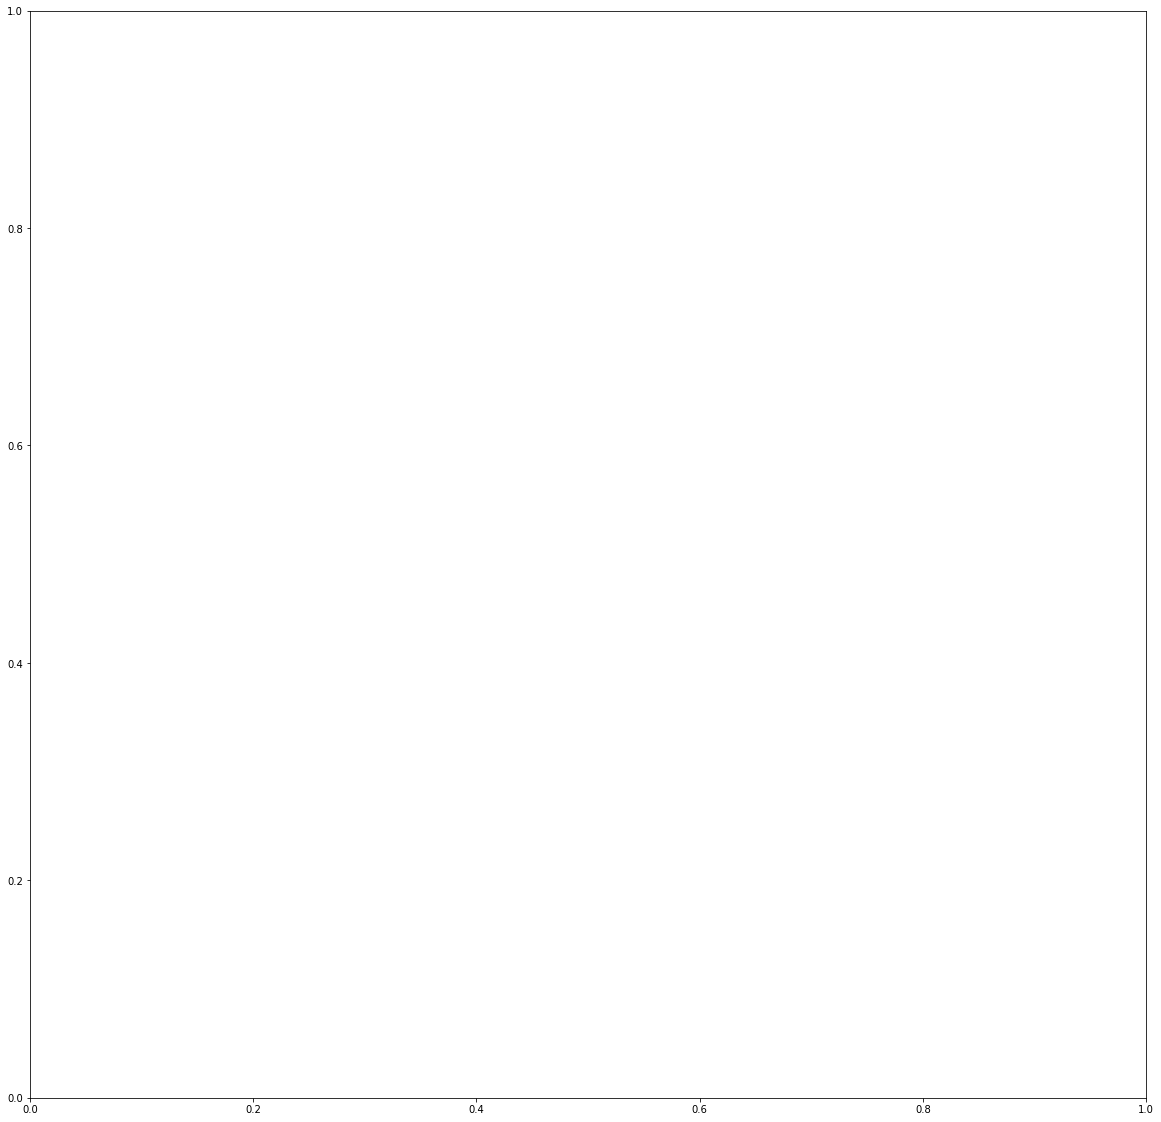

In [144]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
plt.plot(epsilons, fool_rates, "*-")

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 4, step=0.1))
plt.title("Fool Rate vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Fool Rate")
#plt.savefig("WhileLoop.png", dpi = 100, facecolor = 'white')
plt.show()

IndexError: list index out of range

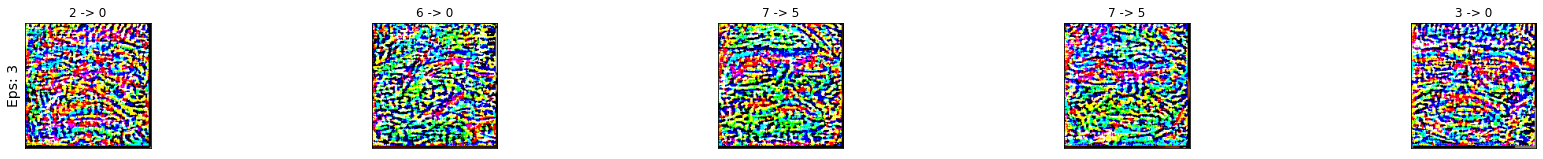

In [66]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
epsilons = [3, 3, 3, 3, 3, 4, 5, 6, 7, 8, 9]
plt.figure(figsize=(30,30))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        ex = np.transpose(ex, (1, 2, 0)).astype(np.float32)
        plt.imshow(ex, cmap='Blues')
plt.tight_layout()
#plt.savefig("Epsilon-Perturbation.png", dpi = 100, facecolor = 'white')
plt.show()

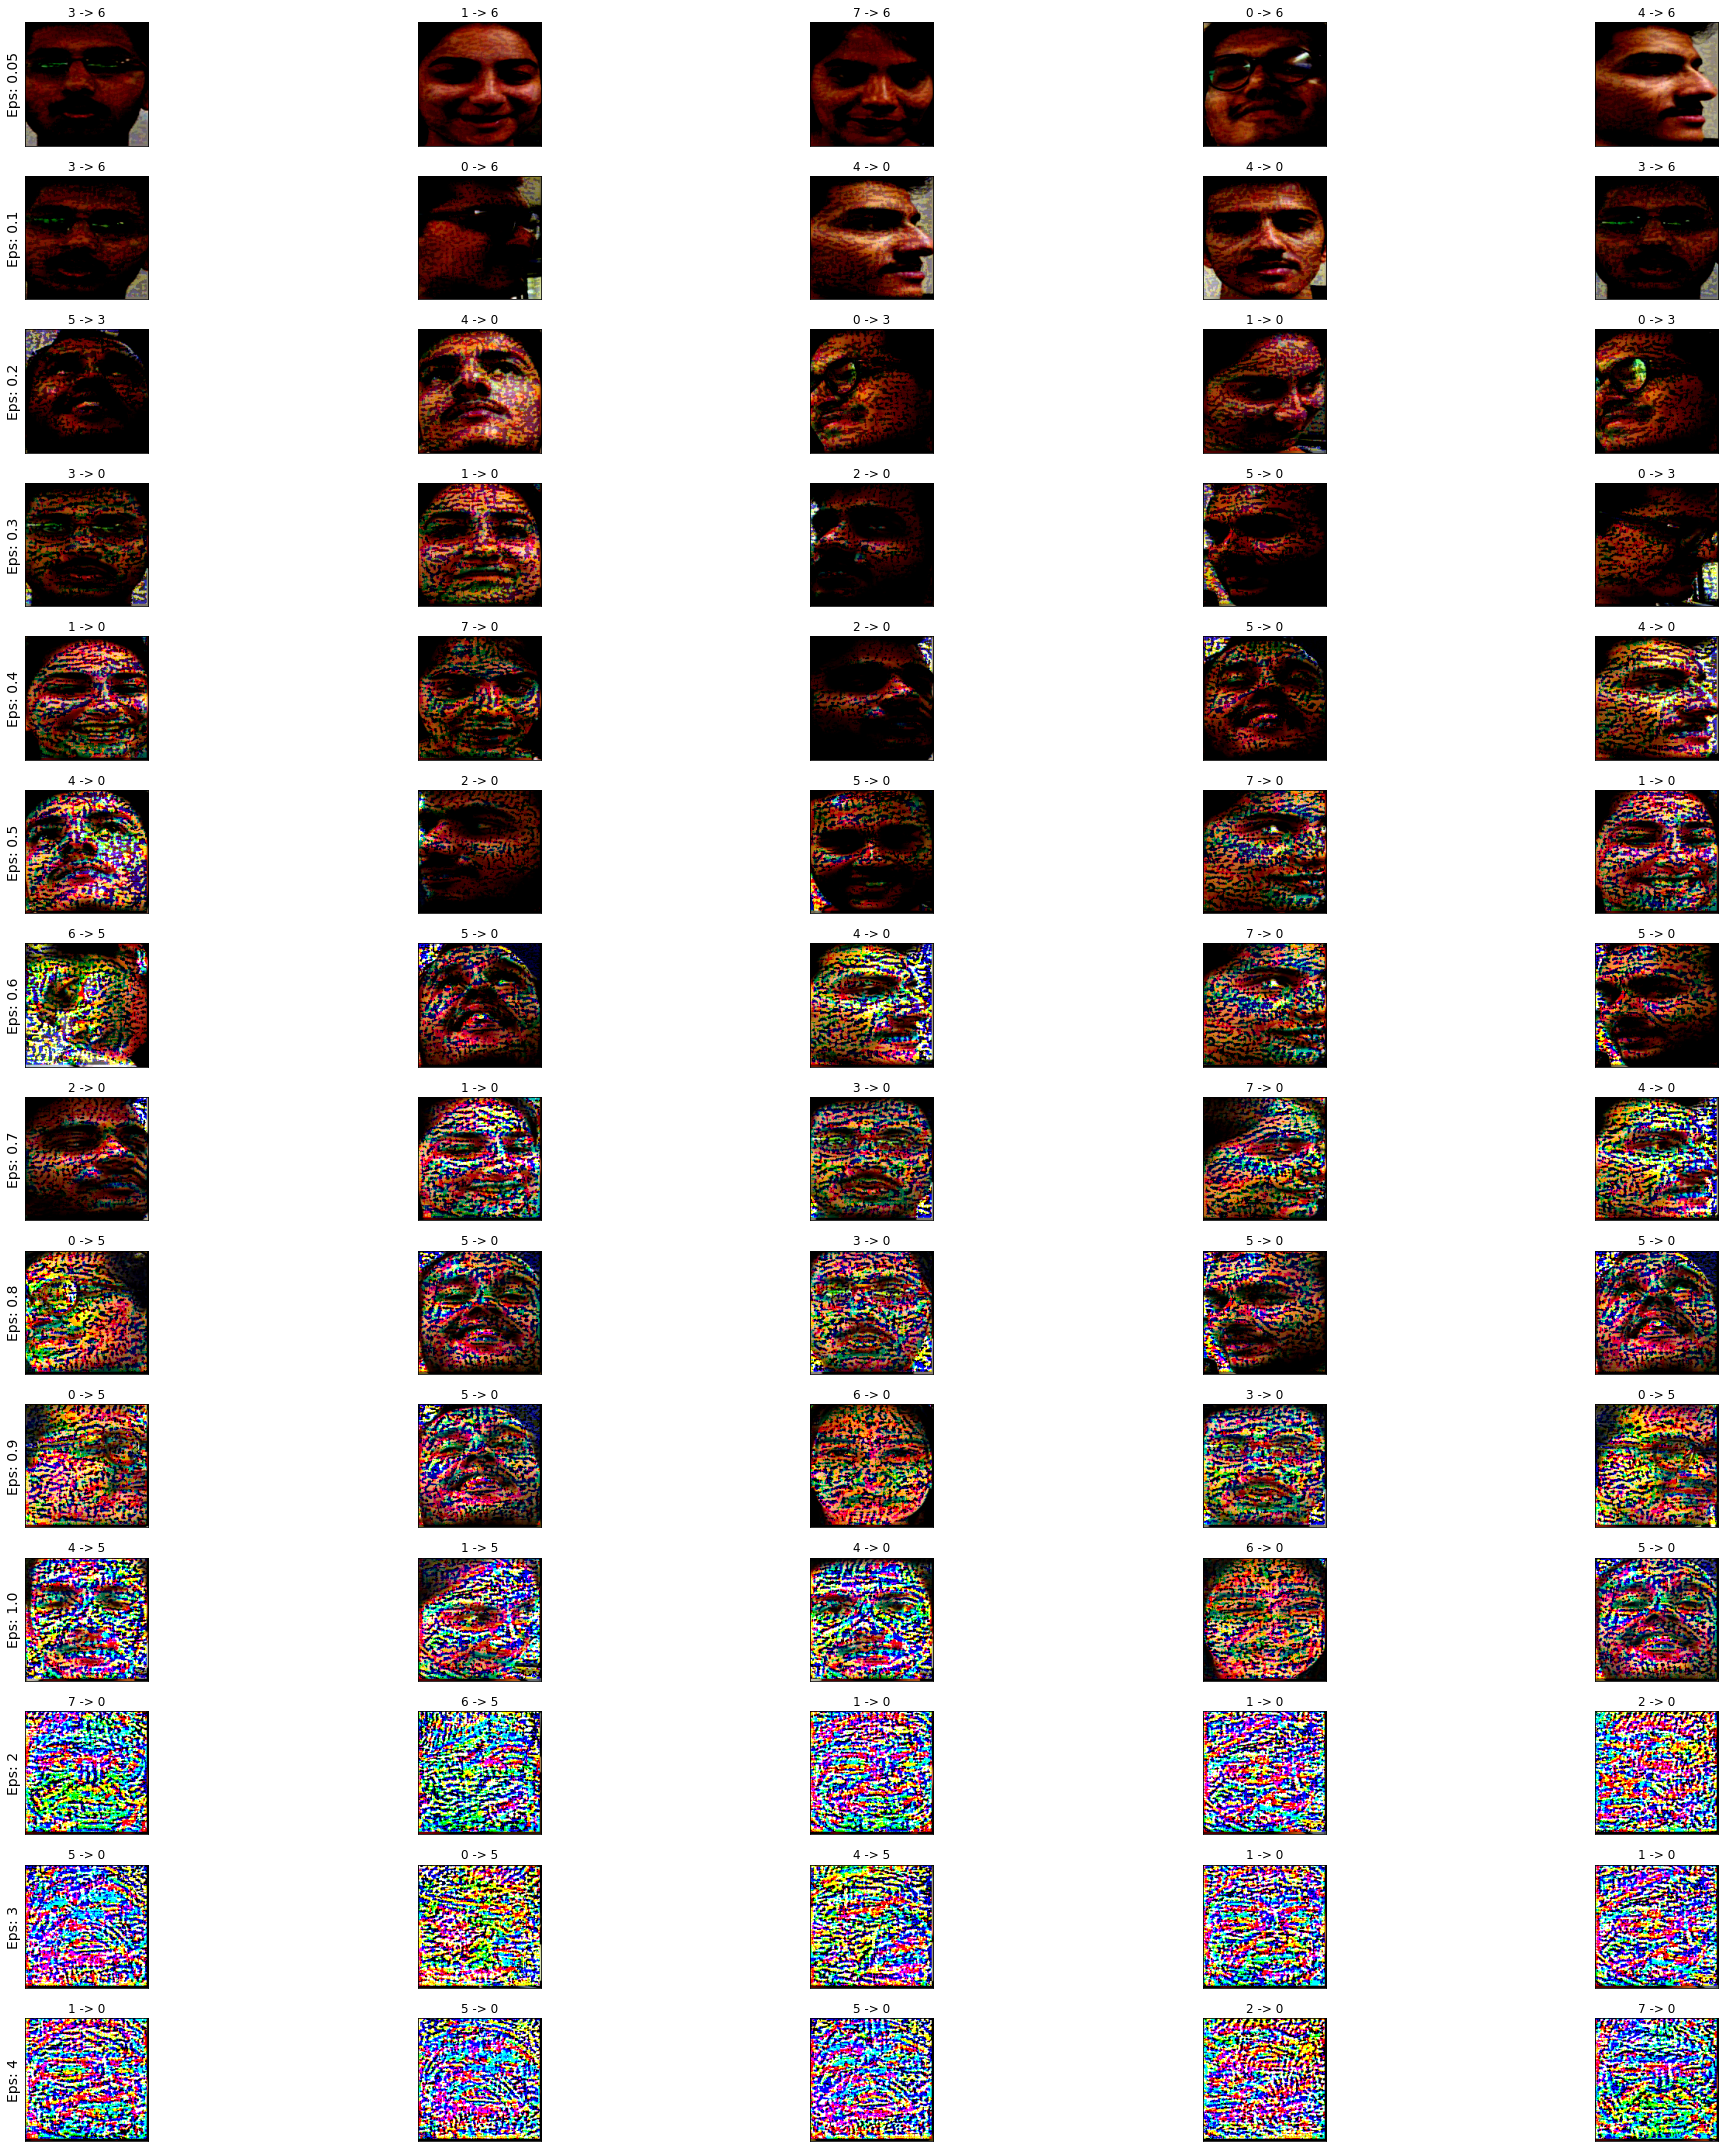

In [76]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(30,30))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        ex = np.transpose(ex, (1, 2, 0)).astype(np.float32)
        plt.imshow(ex, cmap='Blues')
plt.tight_layout()
plt.savefig("Epsilon-Perturbation.png", dpi = 100, facecolor = 'white')
plt.show()

In [52]:
noise_matrix = torch.load('NoiseMatrix.pth')
noise_matrix=noise_matrix.squeeze(0)
noise_matrix.shape

x = torch.load('NoiseMatrix.pth')
x=noise_matrix.squeeze(0)
x.shape

torch.Size([3, 160, 160])

In [70]:
x = torch.zeros(1, 3, 160, 160, device='cuda:0')

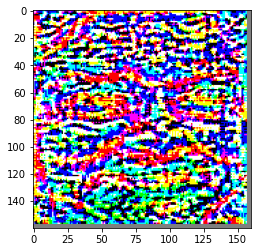

In [71]:
x = x + noise_matrix
plt.imshow(np.transpose(utils.make_grid(x.detach().cpu(), padding=2, normalize=True),(1,2,0)))

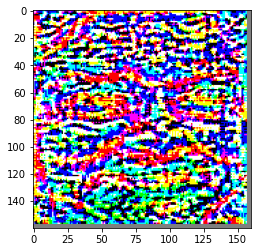

In [55]:
from imports import *
import matplotlib.pyplot as plt
plt.imshow(np.transpose(utils.make_grid(noise_matrix.detach().cpu(), padding=2, normalize=True),(1,2,0)))

In [69]:
torch.eq(x, noise_matrix)

tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ...

In [50]:
x = torch.eq(final_pred, y)
x.sum()

tensor(16)

In [39]:
print(torch.sum(torch.eq(final_pred, y)).item()/y.nelement())

1.0


In [33]:
torch.allclose(final_pred, y)

False

# Imprint Noise Matrix on Glasses

In [2]:
noise_matrix = torch.load('NoiseMatrix.pth')
noise_matrix=noise_matrix.squeeze(0)
noise_matrix.shape

torch.Size([3, 160, 160])

In [31]:
x = noise_matrix.resize_([3, 40, 40])
x.shape

torch.Size([3, 40, 40])

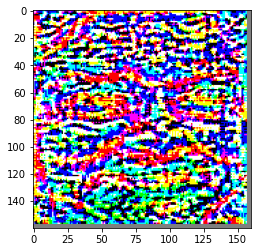

In [3]:
from imports import *
plt.imshow(np.transpose(utils.make_grid(noise_matrix.detach().cpu(), padding=2, normalize=True),(1,2,0)))

In [42]:
np_img = noise_matrix.detach().cpu().numpy()
print(type(np_img))
np_img.shape

<class 'numpy.ndarray'>


(3, 160, 160)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


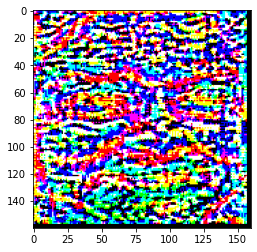

In [43]:
np_img = np.transpose(np_img, (1,2,0))
plt.imshow(np_img)

In [ ]:
gauss = gauss.reshape(img.shape[0],img.shape[1],img.shape[2]).astype('uint8')


Glass shape (224, 224, 3)


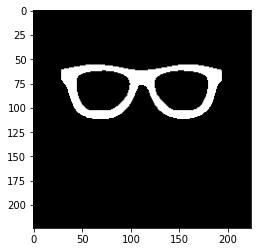

In [28]:
import matplotlib.pyplot as plt

imgGlass = cv2.imread("facenet_pytorch/data/glasses_mask.png", -1)
print("Glass shape", imgGlass.shape)

img = cv2.cvtColor(imgGlass, cv2.COLOR_BGR2RGB)
plt.imshow(img)



In [26]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

transform = A.Compose([
    ToTensorV2()
])

# Read an image with OpenCV and convert it to the RGB colorspace
imgGlass = cv2.imread("facenet_pytorch/data/glasses_mask.png")
imgGlass = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

r = 160.0 / imgGlass.shape[1]
dim = (160, int(imgGlass.shape[0] * r))
#print("What is r - {}, dim - {}".format(r, dim))
#r = 300.0 / imgGlass.shape[1]
#dim = (300, int(imgGlass.shape[0] * r))
imgGlass = cv2.resize(imgGlass, dim, interpolation = cv2.INTER_AREA)
imgGlass = imgGlass[39:81, 21:138]

#plt.imshow(imgGlass)

# Augment an image
transformed = transform(image=imgGlass)
transformed_image = transformed["image"]

transformed_image.shape

torch.Size([3, 42, 117])

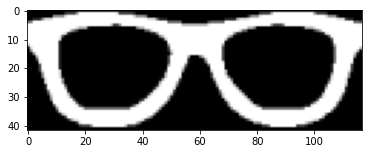

In [27]:
plt.imshow(np.transpose(utils.make_grid(transformed_image.detach().cpu(), padding=2, normalize=False),(1,2,0)))

0

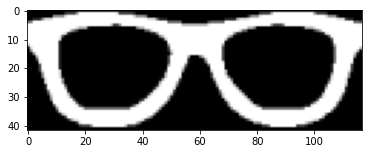

In [112]:
r = 160.0 / imgGlass.shape[1]
dim = (160, int(imgGlass.shape[0] * r))
#print("What is r - {}, dim - {}".format(r, dim))
#r = 300.0 / imgGlass.shape[1]
#dim = (300, int(imgGlass.shape[0] * r))
imgGlass = cv2.resize(imgGlass, dim, interpolation = cv2.INTER_AREA)
imgGlass = imgGlass[39:81, 21:138]

plt.imshow(imgGlass)

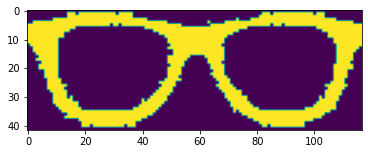

In [116]:
alpha_data = imgGlass[:,:,0] + imgGlass[:,:,1] + imgGlass[:,:,2]
alpha_data[alpha_data < 200] = 0
alpha_data[alpha_data > 20] = 255
orig_mask_g = alpha_data
orig_mask_inv_g = cv2.bitwise_not(orig_mask_g)
orig_mask_g = orig_mask_g / 255
orig_mask_inv_g = orig_mask_inv_g / 255

plt.imshow(orig_mask_g)

In [141]:
from torch.utils.data import Dataset, DataLoader

class MeDataset(Dataset):
    """Eyeglasses dataset."""

    def __init__(self, csv_file, root_dir, bs, transform_img=None, transform_land=None):
        """
        Args:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.label = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform_img = transform_img
        self.transform_land = transform_land
        self.bs = bs

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                               self.label.iloc[idx, 0])
                        
        
 
                
        #print(names[idx])
        #print(img_name)
        #image = io.imread(names[idx])
        #print(self.label.iloc[idx, 0])
        
        #image = io.imread(img_name)
        
        image = io.imread(self.label.iloc[idx, 0])
        landmarks = self.label.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks, 'label': np.zeros(self.bs).astype('float').reshape(-1, 1)}
        # sample = image
         
        if self.transform_img:
            sample['image'] = self.transform_img(sample['image'])
            
        if self.transform_land:
            sample['landmarks'] = self.transform_land(sample['landmarks'])
            sample['label'] = self.transform_land(sample['label'])
        
        #sample['label'] = sample['label'].reshape(-1).view(-1)

        return sample['image'], sample['landmarks'].reshape(-1), sample['label'].reshape(-1)

In [142]:
import pandas as pd
from skimage import io, transform

t_img = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

t_land = transforms.Compose([
    transforms.ToTensor()
])

#data_dir = 'facenet_pytorch/data/'
#image_datasets = datasets.ImageFolder(data_dir, data_transforms)

image_datasets = MeDataset('facenet_pytorch/data/New.csv', 'facenet_pytorch/data/CustomTrain_cropped/', 
                           bs = 1, transform_img=t_img, transform_land=t_land)


dataloader_me = torch.utils.data.DataLoader(image_datasets, batch_size=1, shuffle=False)

In [143]:
data = next(iter(dataloader_me))

In [163]:
import torch.nn.functional as F
from imports import *

faces, landmarks, labels = next(iter(dataloader_me))

for j in range(faces.size(0)):
    img = torch.tensor(faces[j,:,:,:]).cpu()
    glassHeight,glassWidth = landmarks[j,-2:].int()

    print("Glass Coordinates:", (glassHeight, glassWidth)) 

    x1,x2,y1,y2 = landmarks[j,:-2].int()
    #glass = F.interpolate(fakes, (glassHeight,glassWidth)).cpu()


    #print("Interpolated Glass Shape", glass.shape)

    img2 = img[None,:,y1:y2, x1:x2]
    x, y = img2[0][1].shape

    glass = F.interpolate(torch.rand(1, 1, b , 20), (x,y)).cpu()       # My modification
    #print("Interpolated Glass Shape", glass.shape)

    #mask = F.interpolate(T(orig_mask_g[None,None,:,:]), (glassHeight,glassWidth))
    mask = F.interpolate(T(orig_mask_g[None,None,:,:]), (x, y))    # My modification
    #print("Mask Shape", mask.shape)

    #mask_inv = F.interpolate(T(orig_mask_inv_g[None,None,:,:]), (glassHeight,glassWidth))
    mask_inv = F.interpolate(T(orig_mask_inv_g[None,None,:,:]), (x, y))  # My modification

    #print("Mask Inv Shape", mask_inv.shape)

    roi1 = img[None,:,y1:y2, x1:x2]
    
    roi1, mask = roi1.cuda(), mask.cuda()

    roi_bg = roi1 - mask
    roi_bg = torch.clamp(roi_bg, 0)
    glass = glass.cuda()
    roi_fg = glass + mask_inv

    #print("Img Shape", img.shape)
    #print("Glass shape", glass.shape)
    #print("ROI BG shape", roi_bg.shape)

    img[:,y1:y2, x1:x2] = glass[j] + roi_bg[0]
    faces[j,:,:,:] = img

    faces = torch.tensor(faces).to(device)



Glass Coordinates: (tensor(114, dtype=torch.int32), tensor(152, dtype=torch.int32))


<ipython-input-163-d324f768dbf8>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(faces[j,:,:,:]).cpu()
<ipython-input-163-d324f768dbf8>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  faces = torch.tensor(faces).to(device)


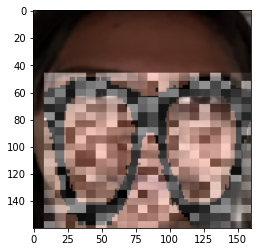

In [164]:
plt.imshow(np.transpose(utils.make_grid(faces.detach().cpu(), padding=2, normalize=True),(1,2,0)))

In [92]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3, .4, .5, .6, .7, .8, .9, 1.0]

resnet.eval()

# Run test for each epsilon
for eps in epsilons:
    acc, ex =  pass_epoch(
        resnet, eps, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    accuracies.append(acc)
    examples.append(ex)
    
writer.close()

Epsilon: 0	Test Accuracy = 6 / 94 = 0.06382978723404255
Epsilon: 0.05	Test Accuracy = 6 / 94 = 0.06382978723404255
Epsilon: 0.1	Test Accuracy = 5 / 94 = 0.05319148936170213
Epsilon: 0.15	Test Accuracy = 12 / 94 = 0.1276595744680851
Epsilon: 0.2	Test Accuracy = 20 / 94 = 0.2127659574468085
Epsilon: 0.25	Test Accuracy = 18 / 94 = 0.19148936170212766
Epsilon: 0.3	Test Accuracy = 17 / 94 = 0.18085106382978725
Epsilon: 0.4	Test Accuracy = 15 / 94 = 0.1595744680851064
Epsilon: 0.5	Test Accuracy = 15 / 94 = 0.1595744680851064
Epsilon: 0.6	Test Accuracy = 15 / 94 = 0.1595744680851064
Epsilon: 0.7	Test Accuracy = 13 / 94 = 0.13829787234042554
Epsilon: 0.8	Test Accuracy = 6 / 94 = 0.06382978723404255
Epsilon: 0.9	Test Accuracy = 5 / 94 = 0.05319148936170213
Epsilon: 1.0	Test Accuracy = 3 / 94 = 0.031914893617021274


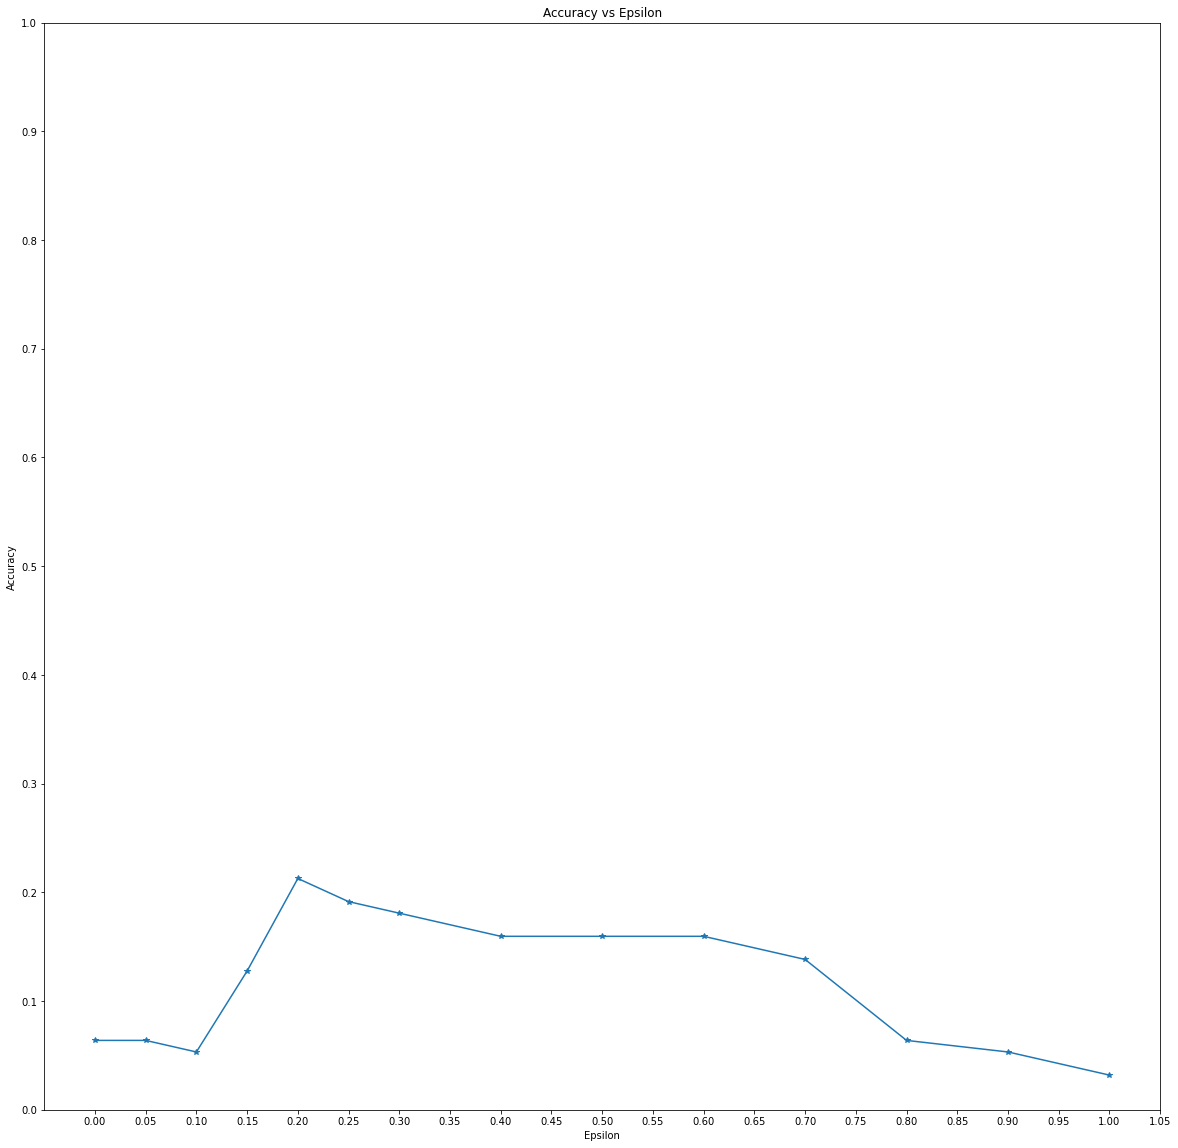

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
plt.plot(epsilons, accuracies, "*-")

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 1.1, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.savefig("output2.png", dpi = 100, facecolor = 'white')
plt.show()

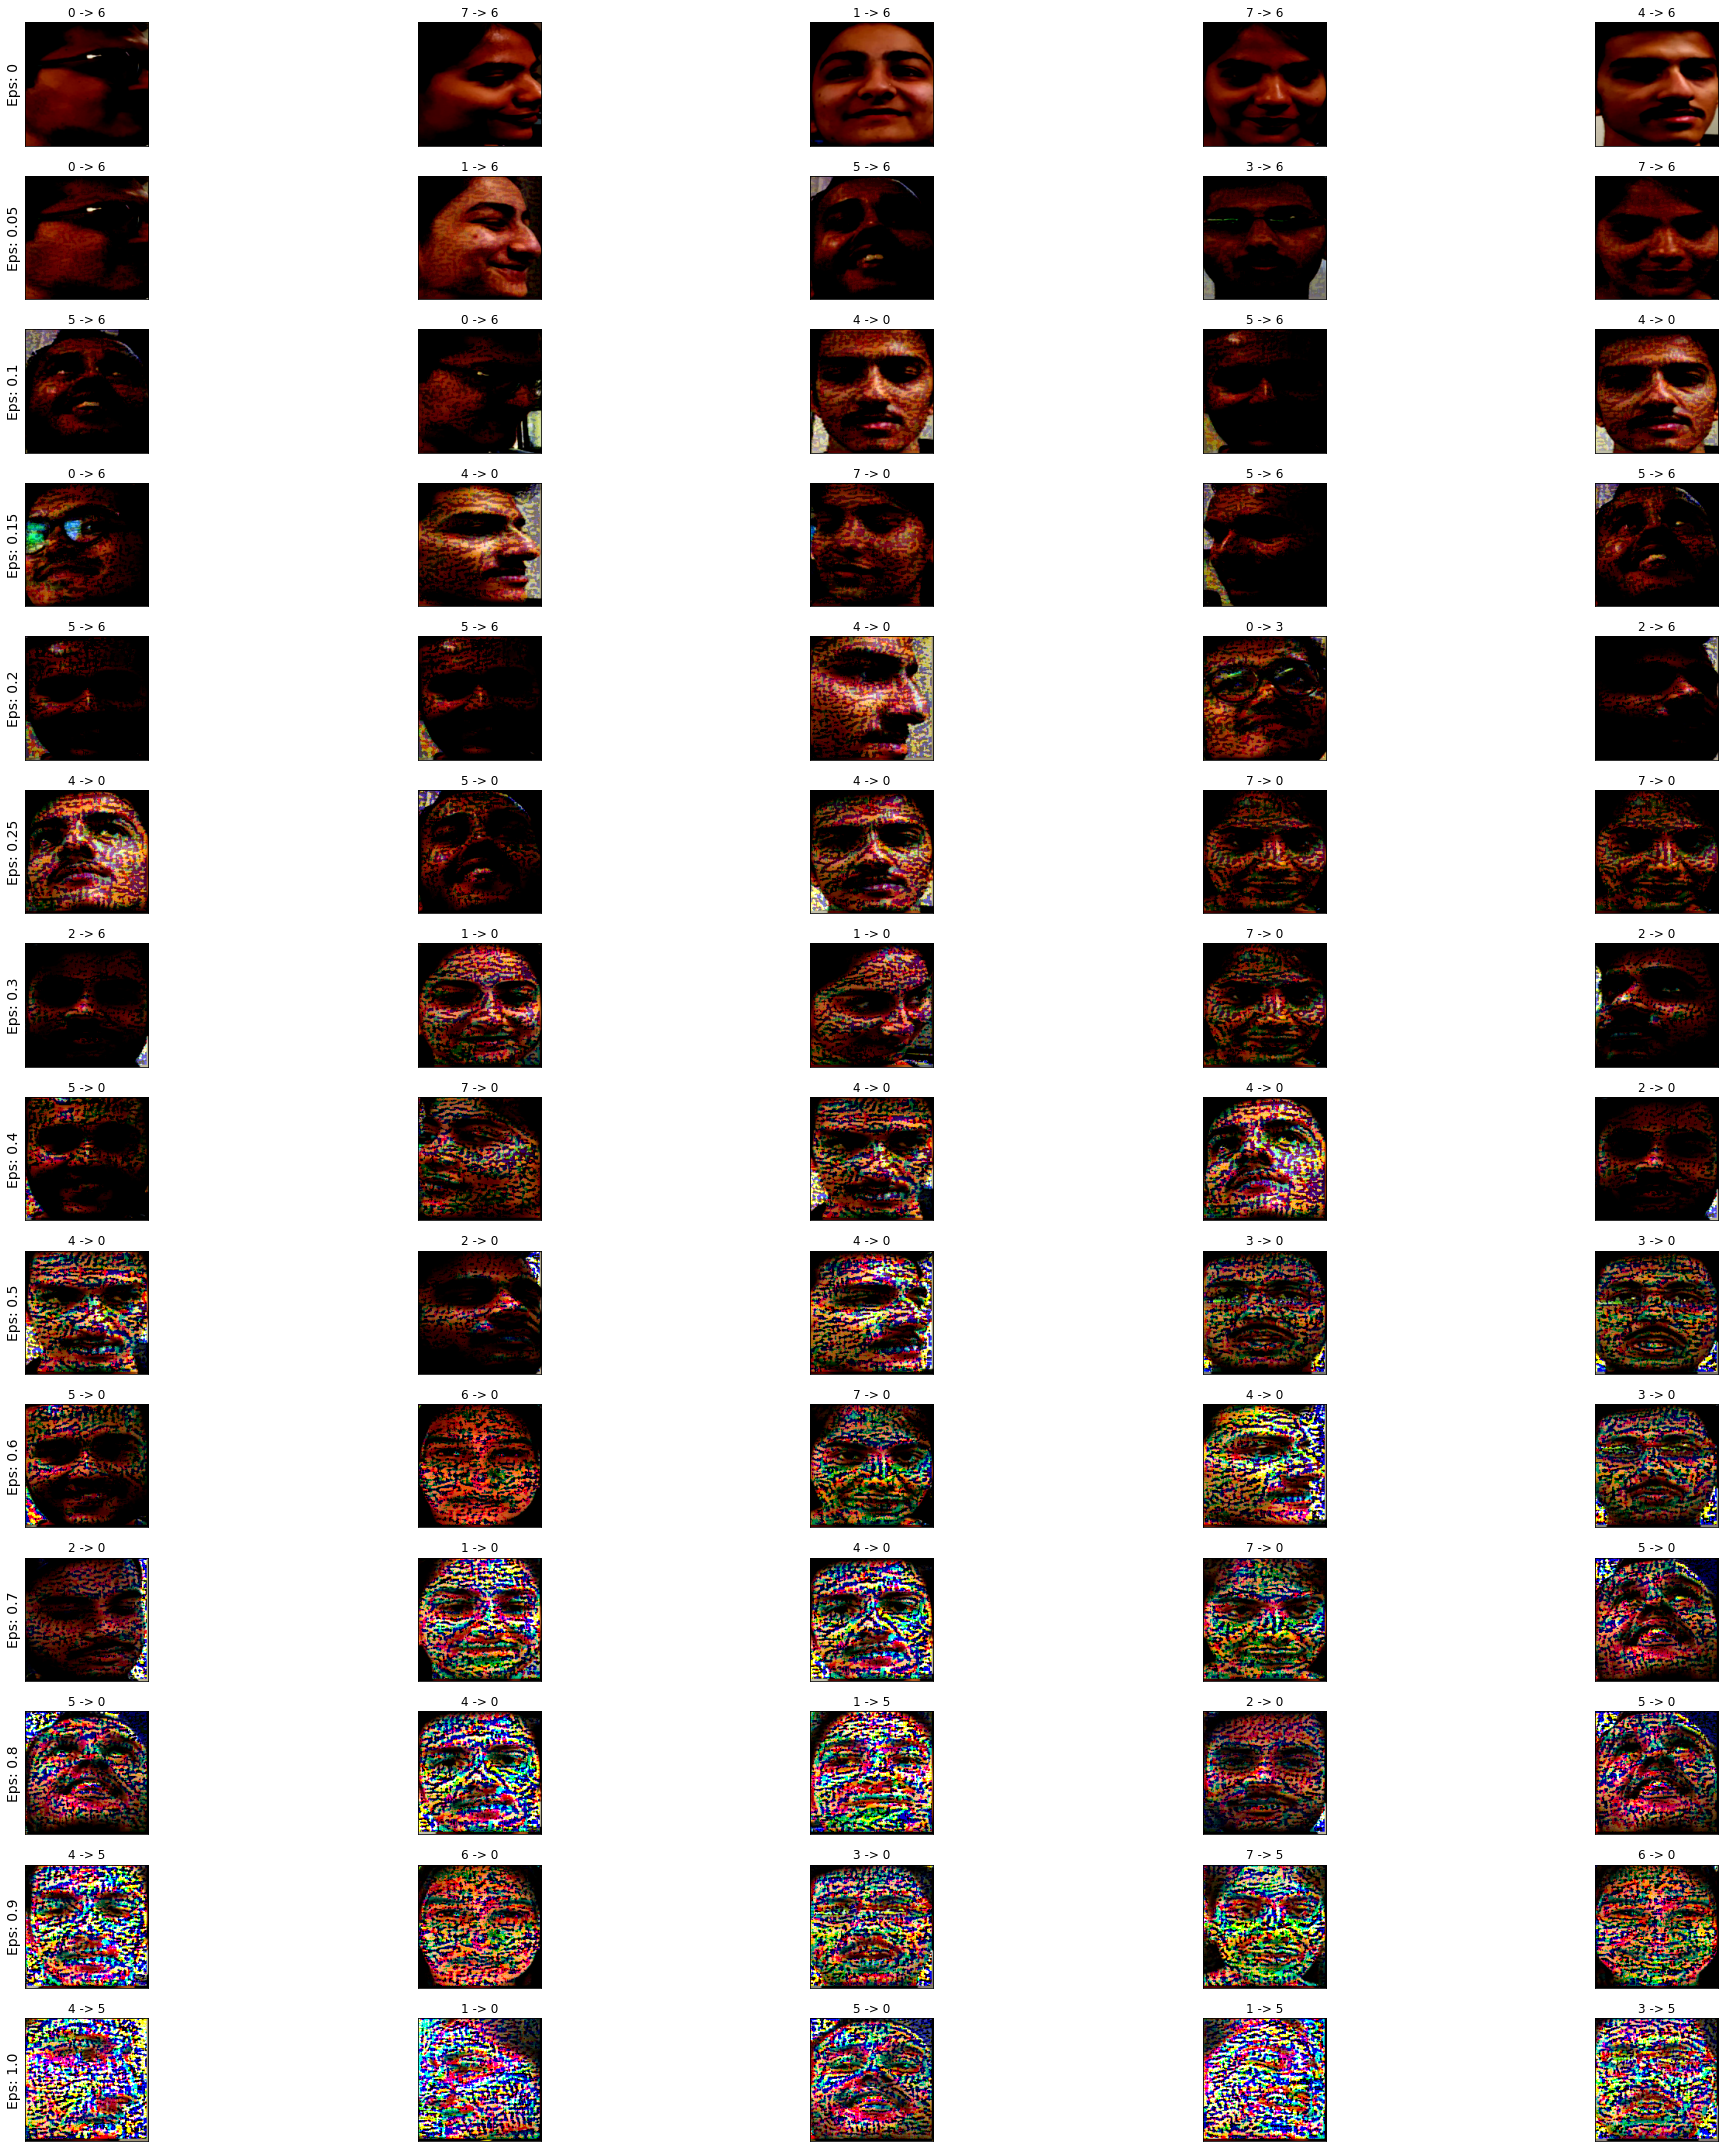

In [93]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(30,30))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        ex = np.transpose(ex, (1, 2, 0)).astype(np.float32)
        plt.imshow(ex, cmap='Blues')
plt.tight_layout()
plt.savefig("Epsilon-Perturbation.png", dpi = 100, facecolor = 'white')
plt.show()

# EyeGlasses try

## Generate Dataset

Attempt only Once

In [20]:
import dlib

from imports import *

In [26]:
pwd

'/home/rushirajsinh/Downloads/AdversarialAttacks/FastAI-OneShot/MyGit/InceptionResnet'

In [16]:
import os
from imutils import paths
names = []
    
path = 'facenet_pytorch/data/CustomTrain_cropped/'

for imgPath in paths.list_images(path):
    names.append(imgPath)

In [29]:
names

['facenet_pytorch/data/CustomTrain_cropped/Vaishvi/vFile591.png',
 'facenet_pytorch/data/CustomTrain_cropped/Vaishvi/vFile5124.png',
 'facenet_pytorch/data/CustomTrain_cropped/Vaishvi/vFile588.png',
 'facenet_pytorch/data/CustomTrain_cropped/Vaishvi/vFile5135.png',
 'facenet_pytorch/data/CustomTrain_cropped/Vaishvi/Vaishvi_20.png',
 'facenet_pytorch/data/CustomTrain_cropped/Vaishvi/vFile5102.png',
 'facenet_pytorch/data/CustomTrain_cropped/Vaishvi/vFile5113.png',
 'facenet_pytorch/data/CustomTrain_cropped/Vaishvi/vFile5137.png',
 'facenet_pytorch/data/CustomTrain_cropped/Vaishvi/vFile599.png',
 'facenet_pytorch/data/CustomTrain_cropped/Vaishvi/vFile5123.png',
 'facenet_pytorch/data/CustomTrain_cropped/Vaishvi/vFile5100.png',
 'facenet_pytorch/data/CustomTrain_cropped/Vaishvi/vFile5106.png',
 'facenet_pytorch/data/CustomTrain_cropped/Vaishvi/vFile590.png',
 'facenet_pytorch/data/CustomTrain_cropped/Vaishvi/vFile5138.png',
 'facenet_pytorch/data/CustomTrain_cropped/Vaishvi/vFile5134.png'

In [133]:
import pandas as pd

pd.concat([
    pd.read_csv('facenet_pytorch/data/bboxes_fnames.csv'), 
    pd.DataFrame(names, columns=['filename'])], 
    axis=1).to_csv('facenet_pytorch/data/New.csv', index=False)

In [19]:
class MeDataset(Dataset):
    """Eyeglasses dataset."""

    def __init__(self, csv_file, root_dir, bs, transform_img=None, transform_land=None):
        """
        Args:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.label = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform_img = transform_img
        self.transform_land = transform_land
        self.bs = bs

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        #img_name = os.path.join(self.root_dir,
                               #self.label.iloc[idx, 0])
                        
  
 
                
        #print(names[idx])
        image = io.imread(names[idx])
        
        #image = io.imread(img_name)
        landmarks = self.label.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks, 'label': np.zeros(self.bs).astype('float').reshape(-1, 1)}
        # sample = image
         
        if self.transform_img:
            sample['image'] = self.transform_img(sample['image'])
            
            
        if self.transform_land:
            sample['landmarks'] = self.transform_land(sample['landmarks'])
            sample['label'] = self.transform_land(sample['label'])
        
        #sample['label'] = sample['label'].reshape(-1).view(-1)

        return sample['image'], sample['landmarks'].reshape(-1), sample['label'].reshape(-1)

In [111]:
t_img = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

t_land = transforms.Compose([
    transforms.ToTensor()
])

#data_dir = 'facenet_pytorch/data/'
#image_datasets = datasets.ImageFolder(data_dir, data_transforms)

image_datasets = MeDataset('facenet_pytorch/data/New.csv', 'facenet_pytorch/data/CustomTrain_cropped/', 
                           bs = 1, transform_img=t_img, transform_land=t_land)


dataloader_me = torch.utils.data.DataLoader(image_datasets, batch_size=1, shuffle=False)

In [112]:
data = next(iter(dataloader_me))

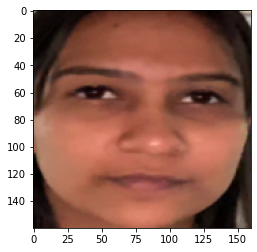

In [113]:
plt.imshow(np.transpose(utils.make_grid(data[0], padding=2, normalize=True),(1,2,0)))

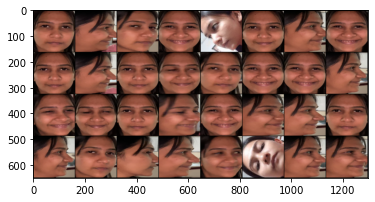

In [94]:
plt.imshow(np.transpose(utils.make_grid(data[0], padding=2, normalize=True),(1,2,0)))

In [21]:
predictor_path = "facenet_pytorch/data/shape_predictor_68_face_landmarks.dat"
face_rec_model_path = "facenet_pytorch/data/dlib_face_recognition_resnet_model_v1.dat"

cnn_face_detector = dlib.cnn_face_detection_model_v1("facenet_pytorch/data/mmod_human_face_detector.dat")
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

In [140]:
coords = []

for frame, _, labels in dataloader_me:
    
    print(frame[0].shape)
    frame = np.transpose(to_np(frame[0]), (1,2,0)) * 255
    frame = frame.astype('uint8')
    #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    print(frame.shape)
    dets = cnn_face_detector(frame, 1)
    try:
        d = dets[0]
    except IndexError:
        #print(frame)
        continue
    #d = dets[0]
    shape = predictor(frame, d.rect)
    
    origGlassHeight, origGlassWidth = frame.shape[:2]
    
    glassWidth = abs(shape.part(16).x - shape.part(1).x)
    glassHeight = int(glassWidth * origGlassHeight / origGlassWidth)

    y1 = int(shape.part(24).y)
    y2 = int(y1 + glassHeight)
    x1 = int(shape.part(27).x - (glassWidth/2))
    x2 = int(x1 + glassWidth)

    if y1 < 0: 
        glassHeight = glassHeight - abs(y1)
        y1 = 0
    if y2 > frame.shape[0]: glassHeight = glassHeight - (y2 - frame.shape[0])
    if x1 < 0: 
        glassWidth = glassWidth - abs(x1)
        x1 = 0
    if x2 > frame.shape[1]: glassWidth = glassWidth - (x2 - frame.shape[1])
    
    coords.append([x1, x2, y1, y2, glassHeight, glassWidth])
    
    

facenet_pytorch/data/CustomTrain_cropped/Vaishvi/vFile591.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Vaishvi/vFile5124.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Vaishvi/vFile588.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Vaishvi/vFile5135.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Vaishvi/Vaishvi_20.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Vaishvi/vFile5102.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Vaishvi/vFile5113.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Vaishvi/vFile5137.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Vaishvi/vFile599.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Vaishvi/vFile5123.png
torch.Size([

facenet_pytorch/data/CustomTrain_cropped/Shakti/Shakti_125.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Shakti/276.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Shakti/266.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Shakti/Shakti_445.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Shakti/368.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Shakti/Shakti_405.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Shakti/366.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Shakti/26 27.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Shakti/12 13.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Shakti/279.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch

facenet_pytorch/data/CustomTrain_cropped/Vidhi/Vidhi_100.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Vidhi/Vidhi_90.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Vidhi/Vidhi_85.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Vidhi/Vidhi_15.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Vidhi/File4116.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Vidhi/File4134.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Vidhi/File4111.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Vidhi/File4133.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Vidhi/File4106.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Vidhi/Vidhi_45.png
torch.Size([3, 160, 160])
(160, 160, 3)

facenet_pytorch/data/CustomTrain_cropped/Rushiraj/rFile5139.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Rushiraj/Rushirajsinh_935.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Rushiraj/rFile5121.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Rushiraj/Rushirajsinh_1000.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Rushiraj/rFile595.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Rushiraj/rFile582.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Rushiraj/Rushiraj_100.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Rushiraj/rFile5112.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Rushiraj/rFile5136.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Rushira

facenet_pytorch/data/CustomTrain_cropped/Ishan/File3111.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Ishan/File3154.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Ishan/File3110.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Ishan/File3121.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Ishan/Ishan_100.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Ishan/Ishan_40.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Ishan/File3139.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Ishan/File3155.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Ishan/Ishan_90.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Ishan/File3103.png
torch.Size([3, 160, 160])
(160, 160, 3)

facenet_pytorch/data/CustomTrain_cropped/Tirthraj/File 132.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Tirthraj/Tirthraj_315.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Rahul/50.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Rahul/73.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Rahul/77.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Rahul/49.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Rahul/85.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Rahul/Rahul_215.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Rahul/43.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrain_cropped/Rahul/55.png
torch.Size([3, 160, 160])
(160, 160, 3)
facenet_pytorch/data/CustomTrai

In [142]:
pd.concat([
    pd.read_csv('facenet_pytorch/data/New.csv'), 
    pd.DataFrame(coords, columns=['x1','x2','y1','y2','h','w'])], 
    axis=1).to_csv('facenet_pytorch/data/New.csv', index=False)

# Try Training

In [22]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [26]:
train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=1,
    sampler=SubsetRandomSampler(train_inds)
)

val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=1,
    sampler=SubsetRandomSampler(val_inds)
)

In [25]:
import torch
import numpy as np
import time

class Logger(object):

    def __init__(self, mode, length, calculate_mean=False):
        self.mode = mode
        self.length = length
        self.calculate_mean = calculate_mean
        if self.calculate_mean:
            self.fn = lambda x, i: x / (i + 1)
        else:
            self.fn = lambda x, i: x

    def __call__(self, loss, metrics, i):
        track_str = '\r{} | {:5d}/{:<5d}| '.format(self.mode, i + 1, self.length)
        loss_str = 'loss: {:9.4f} | '.format(self.fn(loss, i))
        metric_str = ' | '.join('{}: {:9.4f}'.format(k, self.fn(v, i)) for k, v in metrics.items())
        print(track_str + loss_str + metric_str + '   ', end='')
        if i + 1 == self.length:
            print('')


class BatchTimer(object):
    """Batch timing class.
    Use this class for tracking training and testing time/rate per batch or per sample.
    
    Keyword Arguments:
        rate {bool} -- Whether to report a rate (batches or samples per second) or a time (seconds
            per batch or sample). (default: {True})
        per_sample {bool} -- Whether to report times or rates per sample or per batch.
            (default: {True})
    """

    def __init__(self, rate=True, per_sample=True):
        self.start = time.time()
        self.end = None
        self.rate = rate
        self.per_sample = per_sample

    def __call__(self, y_pred, y):
        self.end = time.time()
        elapsed = self.end - self.start
        self.start = self.end
        self.end = None

        if self.per_sample:
            elapsed /= len(y_pred)
        if self.rate:
            elapsed = 1 / elapsed

        return torch.tensor(elapsed)


def accuracy(logits, y):
    _, preds = torch.max(logits, 1)
    return (preds == y).float().mean()

class_names = [
    'Ishan','Janvi','Rahul','Rushiraj','Shakti',
    'Tirthraj','Vaishvi','Vidhi']

def pass_epoch(
    model, epsilon, loss_fn, loader, optimizer=None, scheduler=None,
    batch_metrics={'time': BatchTimer()}, show_running=True,
    device='cpu', writer=None
):
    
    mode = 'Train' if model.training else 'Valid'
    logger = Logger(mode, length=len(loader), calculate_mean=show_running)
    loss = 0
    metrics = {}

    correct = 0
    adv_examples = []
    
    me_label = [i for i, el in enumerate(class_names)][0]
    #print('me_label: ', me_label)
    
    # Get masks
    imgGlass = cv2.imread("facenet_pytorch/data/glasses_mask.png", -1)
    #print("Glass shape", imgGlass.shape)
    r = 160.0 / imgGlass.shape[1]
    dim = (160, int(imgGlass.shape[0] * r))
    #print("What is r - {}, dim - {}".format(r, dim))
    #r = 300.0 / imgGlass.shape[1]
    #dim = (300, int(imgGlass.shape[0] * r))
    imgGlass = cv2.resize(imgGlass, dim, interpolation = cv2.INTER_AREA)
    imgGlass = imgGlass[39:81, 21:138]
 
    alpha_data = imgGlass[:,:,0] + imgGlass[:,:,1] + imgGlass[:,:,2]
    alpha_data[alpha_data < 200] = 0
    alpha_data[alpha_data > 20] = 255
    orig_mask_g = alpha_data
    orig_mask_inv_g = cv2.bitwise_not(orig_mask_g)
    orig_mask_g = orig_mask_g / 255
    orig_mask_inv_g = orig_mask_inv_g / 255
    
    count = 0

    #for X, y in enumerate(loader):
    for X,y in loader:
        count+=1
        print(count)

        X = X.to(device)
        y_orig = y.to(device)
        
        
        faces, landmarks, labels = next(iter(dataloader_me))
            
        for j in range(faces.size(0)):
            img = torch.tensor(faces[j,:,:,:]).cpu()
            glassHeight,glassWidth = landmarks[j,-2:].int()

            #print("Glass Coordinates:", (glassHeight, glassWidth)) 

            x1,x2,y1,y2 = landmarks[j,:-2].int()
            #glass = F.interpolate(fakes, (glassHeight,glassWidth)).cpu()


            #print("Interpolated Glass Shape", glass.shape)

            img2 = img[None,:,y1:y2, x1:x2]
            x, y = img2[0][1].shape

            glass = F.interpolate(torch.rand(1, 1, 160, 160), (x,y)).cpu()       # My modification
            #print("Interpolated Glass Shape", glass.shape)

            #mask = F.interpolate(T(orig_mask_g[None,None,:,:]), (glassHeight,glassWidth))
            mask = F.interpolate(T(orig_mask_g[None,None,:,:]), (x, y))    # My modification
            #print("Mask Shape", mask.shape)

            #mask_inv = F.interpolate(T(orig_mask_inv_g[None,None,:,:]), (glassHeight,glassWidth))
            mask_inv = F.interpolate(T(orig_mask_inv_g[None,None,:,:]), (x, y))  # My modification

            #print("Mask Inv Shape", mask_inv.shape)

            roi1 = img[None,:,y1:y2, x1:x2]

            #print("img", img.shape)


            #print("ROI1 shape", roi1.shape)

            #print("x1 - {},  x2 - {},  y1 - {},  y2 - {}". format(x1, x2, y1, y2))

            roi1, mask = roi1.cuda(), mask.cuda()

            roi_bg = roi1 - mask
            roi_bg = torch.clamp(roi_bg, 0)
            glass = glass.cuda()
            roi_fg = glass + mask_inv
            
            #print("Img Shape", img.shape)
            #print("Glass shape", glass.shape)
            #print("ROI BG shape", roi_bg.shape)
            
            img[:,y1:y2, x1:x2] = glass[j] + roi_bg[0]
            faces[j,:,:,:] = img
                
            faces = torch.tensor(faces).to(device)

            X.requires_grad = True

            faces.requires_grad = True
            y_pred = model(faces)

            #print(y_pred.type)
            #print(y_orig.dtype)
            loss_batch = loss_fn(y_pred, y_orig)

            init_pred = y_pred.max(1, keepdim=True)[1] # get the index of the max log-probability


            # If the initial prediction is wrong, dont bother attacking, just move on
            if init_pred.item() != y_orig.item():
                print("INSIDE")
                print(init_pred, y_orig)
                continue

            model.zero_grad()
            loss_batch.backward()

            data_grad = faces.grad.data

            # Call FGSM Attack
            perturbed_data = fgsm_attack(faces, epsilon, data_grad)
            output = model(perturbed_data)

             # Check for success
            final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            if final_pred.item() == y_orig.item():
                correct += 1
                # Special case for saving 0 epsilon examples
                if (epsilon == 0) and (len(adv_examples) < 5):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

        # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(loader), final_acc))



    #return loss, metrics
    return final_acc, adv_examples


def collate_pil(x): 
    out_x, out_y = [], [] 
    for xx, yy in x: 
        out_x.append(xx) 
        out_y.append(yy) 
    return out_x, out_y 


In [27]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3]

resnet.eval()

# Run test for each epsilon
for eps in epsilons:
    acc, ex =  pass_epoch(
        resnet, eps, loss_fn, train_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    accuracies.append(acc)
    examples.append(ex)
    
writer.close()

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/rushirajsinh/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/rushirajsinh/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/home/rushirajsinh/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 83, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/home/rushirajsinh/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 83, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/home/rushirajsinh/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 85, in default_collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>


In [44]:
len(train_loader.dataset) 

15

In [34]:
len(dataloader_me.dataset)

470

In [109]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

trans = transforms.Compose([
    np.float32,
    #transforms.ToTensor(),
    fixed_image_standardization,
    transforms.ToTensor()
])
dataset = datasets.ImageFolder('facenet_pytorch/data/CustomTrain_cropped/', transform=trans)
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader3 = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=1,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader3 = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=1,
    sampler=SubsetRandomSampler(val_inds)
)

In [110]:
len(train_loader3.dataset)

470

In [73]:
data = next(iter(train_loader2))

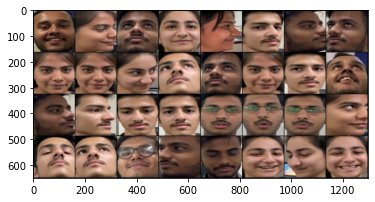

In [74]:
plt.imshow(np.transpose(utils.make_grid(data[0], padding=2, normalize=True),(1,2,0)))

In [70]:
data[0].type

<function Tensor.type>

In [121]:
data = next(iter(dataloader_me))

In [122]:
data

[tensor([[[[0.6157, 0.5412, 0.2706,  ..., 0.7529, 0.7765, 0.7804],
           [0.5255, 0.3686, 0.1804,  ..., 0.6980, 0.7059, 0.7137],
           [0.3176, 0.1765, 0.1216,  ..., 0.5765, 0.5765, 0.5804],
           ...,
           [0.0275, 0.0314, 0.0588,  ..., 0.2667, 0.2118, 0.2039],
           [0.0275, 0.0392, 0.0627,  ..., 0.2588, 0.2078, 0.1961],
           [0.0275, 0.0392, 0.0549,  ..., 0.2510, 0.2000, 0.1882]],
 
          [[0.6118, 0.5333, 0.2627,  ..., 0.7098, 0.7255, 0.7294],
           [0.5216, 0.3608, 0.1647,  ..., 0.6549, 0.6588, 0.6667],
           [0.3176, 0.1686, 0.1059,  ..., 0.5333, 0.5333, 0.5373],
           ...,
           [0.0078, 0.0118, 0.0314,  ..., 0.2157, 0.1569, 0.1412],
           [0.0078, 0.0157, 0.0314,  ..., 0.2118, 0.1569, 0.1373],
           [0.0078, 0.0157, 0.0235,  ..., 0.2039, 0.1529, 0.1333]],
 
          [[0.5686, 0.4941, 0.2353,  ..., 0.6353, 0.6510, 0.6549],
           [0.4745, 0.3216, 0.1373,  ..., 0.5843, 0.5961, 0.6000],
           [0.2667, 0.12

In [200]:
class MeDataset(Dataset):
    """Eyeglasses dataset."""

    def __init__(self, csv_file, root_dir, bs, transform_img=None, transform_land=None):
        """
        Args:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.label = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform_img = transform_img
        self.transform_land = transform_land
        self.bs = bs

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        #img_name = os.path.join(self.root_dir,
                               #self.label.iloc[idx, 0])
                        
        
 
                
        #print(names[idx])
        image = io.imread(names[idx])
        
        #image = io.imread(img_name)
        landmarks = self.label.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks, 'label': np.zeros(self.bs).astype('float').reshape(-1, 1)}
        # sample = image
         
        if self.transform_img:
            sample['image'] = self.transform_img(sample['image'])
            
        if self.transform_land:
            sample['landmarks'] = self.transform_land(sample['landmarks'])
            sample['label'] = self.transform_land(sample['label'])
        
        #sample['label'] = sample['label'].reshape(-1).view(-1)

        return sample['image'], sample['landmarks'].reshape(-1), sample['label'].reshape(-1)

In [201]:
t_img = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

t_land = transforms.Compose([
    transforms.ToTensor()
])

#data_dir = 'facenet_pytorch/data/'
#image_datasets = datasets.ImageFolder(data_dir, data_transforms)

image_datasets = MeDataset('facenet_pytorch/data/New.csv', 'facenet_pytorch/data/CustomTrain_cropped/', 
                           bs = 1, transform_img=t_img, transform_land=t_land)


dataloader_me = torch.utils.data.DataLoader(image_datasets, batch_size=1, shuffle=False)

In [202]:
data = next(iter(dataloader_me))
data

[tensor([[[[0.6157, 0.5412, 0.2706,  ..., 0.7529, 0.7765, 0.7804],
           [0.5255, 0.3686, 0.1804,  ..., 0.6980, 0.7059, 0.7137],
           [0.3176, 0.1765, 0.1216,  ..., 0.5765, 0.5765, 0.5804],
           ...,
           [0.0275, 0.0314, 0.0588,  ..., 0.2667, 0.2118, 0.2039],
           [0.0275, 0.0392, 0.0627,  ..., 0.2588, 0.2078, 0.1961],
           [0.0275, 0.0392, 0.0549,  ..., 0.2510, 0.2000, 0.1882]],
 
          [[0.6118, 0.5333, 0.2627,  ..., 0.7098, 0.7255, 0.7294],
           [0.5216, 0.3608, 0.1647,  ..., 0.6549, 0.6588, 0.6667],
           [0.3176, 0.1686, 0.1059,  ..., 0.5333, 0.5333, 0.5373],
           ...,
           [0.0078, 0.0118, 0.0314,  ..., 0.2157, 0.1569, 0.1412],
           [0.0078, 0.0157, 0.0314,  ..., 0.2118, 0.1569, 0.1373],
           [0.0078, 0.0157, 0.0235,  ..., 0.2039, 0.1529, 0.1333]],
 
          [[0.5686, 0.4941, 0.2353,  ..., 0.6353, 0.6510, 0.6549],
           [0.4745, 0.3216, 0.1373,  ..., 0.5843, 0.5961, 0.6000],
           [0.2667, 0.12

In [28]:
from imutils import paths
import dlib
from imports import *
import pandas as pd


class NewDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, bs, transform_img=None, transform_land=None):
        
        self.land = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform_img = transform_img
        self.transform_land = transform_land
        self.bs = bs
        
    def __len__(self):

        return len(self.land) 

    def __getitem__(self, idx):

        name = self.land.iloc[idx, 0]
        image = io.imread(name)

        temp = name.split('/')[-2]

        if temp == 'Vaishvi':
            label = torch.tensor([1, 0, 0, 0, 0, 0, 0, 0])

        elif temp == 'Shakti':
            label = torch.tensor([0, 1, 0, 0, 0, 0, 0, 0])

        elif temp == 'Vidhi':
            label = torch.tensor([0, 0, 1, 0, 0, 0, 0, 0])

        elif temp == 'Janvi':
            label = torch.tensor([0, 0, 0, 1, 0, 0, 0, 0])

        elif temp == 'Rushiraj':
            label = torch.tensor([0, 0, 0, 0, 1, 0, 0, 0])

        elif temp == 'Ishan':
            label = torch.tensor([0, 0, 0, 0, 0, 1, 0, 0])

        elif temp == 'Tirthraj':
            label = torch.tensor([0, 0, 0, 0, 0, 0, 1, 0])

        elif temp == 'Rahul':
            label = torch.tensor([0, 0, 0, 0, 0, 0, 0, 1])

        landmarks = self.land.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)

        sample = {'image': image, 'landmarks': landmarks, 'label': label}

        if self.transform_img:
            sample['image'] = self.transform_img(sample['image'])

        if self.transform_land:
            sample['landmarks'] = self.transform_land(sample['landmarks'])


        return sample['image'], sample['landmarks'].reshape(-1), label

In [29]:
t_img = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

t_land = transforms.Compose([
    transforms.ToTensor()
])

#data_dir = 'facenet_pytorch/data/'
#image_datasets = datasets.ImageFolder(data_dir, data_transforms)

image_datasets = NewDataset('facenet_pytorch/data/New.csv', 'facenet_pytorch/data/CustomTrain_cropped/', 
                           bs = 1, transform_img=t_img, transform_land=t_land)


dataloader_me = torch.utils.data.DataLoader(image_datasets, batch_size=1, shuffle=False)

In [31]:
data = next(iter(dataloader_me))
data[2]

tensor([[1, 0, 0, 0, 0, 0, 0, 0]])

In [35]:
import torch
import numpy as np
import time

class Logger(object):

    def __init__(self, mode, length, calculate_mean=False):
        self.mode = mode
        self.length = length
        self.calculate_mean = calculate_mean
        if self.calculate_mean:
            self.fn = lambda x, i: x / (i + 1)
        else:
            self.fn = lambda x, i: x

    def __call__(self, loss, metrics, i):
        track_str = '\r{} | {:5d}/{:<5d}| '.format(self.mode, i + 1, self.length)
        loss_str = 'loss: {:9.4f} | '.format(self.fn(loss, i))
        metric_str = ' | '.join('{}: {:9.4f}'.format(k, self.fn(v, i)) for k, v in metrics.items())
        print(track_str + loss_str + metric_str + '   ', end='')
        if i + 1 == self.length:
            print('')


class BatchTimer(object):
    """Batch timing class.
    Use this class for tracking training and testing time/rate per batch or per sample.
    
    Keyword Arguments:
        rate {bool} -- Whether to report a rate (batches or samples per second) or a time (seconds
            per batch or sample). (default: {True})
        per_sample {bool} -- Whether to report times or rates per sample or per batch.
            (default: {True})
    """

    def __init__(self, rate=True, per_sample=True):
        self.start = time.time()
        self.end = None
        self.rate = rate
        self.per_sample = per_sample

    def __call__(self, y_pred, y):
        self.end = time.time()
        elapsed = self.end - self.start
        self.start = self.end
        self.end = None

        if self.per_sample:
            elapsed /= len(y_pred)
        if self.rate:
            elapsed = 1 / elapsed

        return torch.tensor(elapsed)


def accuracy(logits, y):
    _, preds = torch.max(logits, 1)
    return (preds == y).float().mean()

class_names = [
    'Ishan','Janvi','Rahul','Rushiraj','Shakti',
    'Tirthraj','Vaishvi','Vidhi']

def pass_epoch(
    model, epsilon, loss_fn, loader, optimizer=None, scheduler=None,
    batch_metrics={'time': BatchTimer()}, show_running=True,
    device='cpu', writer=None
):
    
    mode = 'Train' if model.training else 'Valid'
    logger = Logger(mode, length=len(loader), calculate_mean=show_running)
    loss = 0
    metrics = {}

    correct = 0
    adv_examples = []
    
    me_label = [i for i, el in enumerate(class_names)][0]
    #print('me_label: ', me_label)
    
    # Get masks
    imgGlass = cv2.imread("facenet_pytorch/data/glasses_mask.png", -1)
    #print("Glass shape", imgGlass.shape)
    r = 160.0 / imgGlass.shape[1]
    dim = (160, int(imgGlass.shape[0] * r))
    #print("What is r - {}, dim - {}".format(r, dim))
    #r = 300.0 / imgGlass.shape[1]
    #dim = (300, int(imgGlass.shape[0] * r))
    imgGlass = cv2.resize(imgGlass, dim, interpolation = cv2.INTER_AREA)
    imgGlass = imgGlass[39:81, 21:138]
    
    alpha_data = imgGlass[:,:,0] + imgGlass[:,:,1] + imgGlass[:,:,2]
    alpha_data[alpha_data < 200] = 0
    alpha_data[alpha_data > 20] = 255
    orig_mask_g = alpha_data
    orig_mask_inv_g = cv2.bitwise_not(orig_mask_g)
    orig_mask_g = orig_mask_g / 255
    orig_mask_inv_g = orig_mask_inv_g / 255
    
    count = 0
    
    unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    renorm = Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))


        
        
    #faces, landmarks, labels = next(iter(dataloader_me))
    
    for faces, landmarks, labels in dataloader_me:
                    
        for j in range(faces.size(0)):
            
            print(faces.shape, labels.shape)
            #img = torch.tensor(faces[j,:,:,:]).cpu()
            img = unorm(faces[j,:,:,:]).cpu()
            glassHeight,glassWidth = landmarks[j,-2:].int()

            #print("Glass Coordinates:", (glassHeight, glassWidth)) 

            x1,x2,y1,y2 = landmarks[j,:-2].int()
            #glass = F.interpolate(fakes, (glassHeight,glassWidth)).cpu()

            #print("Interpolated Glass Shape", glass.shape)

            img2 = img[None,:,y1:y2, x1:x2]
            x, y = img2[0][1].shape

            glass = F.interpolate(torch.rand(1, 1, 160, 160), (x,y)).cpu()       # My modification
            #print("Interpolated Glass Shape", glass.shape)

            #mask = F.interpolate(T(orig_mask_g[None,None,:,:]), (glassHeight,glassWidth))
            mask = F.interpolate(T(orig_mask_g[None,None,:,:]), (x, y))    # My modification
            #print("Mask Shape", mask.shape)

            #mask_inv = F.interpolate(T(orig_mask_inv_g[None,None,:,:]), (glassHeight,glassWidth))
            mask_inv = F.interpolate(T(orig_mask_inv_g[None,None,:,:]), (x, y))  # My modification

            #print("Mask Inv Shape", mask_inv.shape)

            roi1 = img[None,:,y1:y2, x1:x2]

            #print("img", img.shape)

            #print("ROI1 shape", roi1.shape)

            #print("x1 - {},  x2 - {},  y1 - {},  y2 - {}". format(x1, x2, y1, y2))

            roi1, mask = roi1.cuda(), mask.cuda()

            roi_bg = roi1 - mask
            roi_bg = torch.clamp(roi_bg, 0)
            glass = glass.cuda()
            roi_fg = glass + mask_inv

            
            #print("Img Shape", img.shape)
            #print("Glass shape", glass.shape)
            #print("ROI BG shape", roi_bg.shape)

            img[:,y1:y2, x1:x2] = glass[j] + roi_bg[0]
            faces[j,:,:,:] = img

            #faces = torch.tensor(faces).to(device)
            faces = renorm(faces).to(device)
            #X.requires_grad = True

            faces.requires_grad = True
            print("Faces shape", faces.shape)
            
            y_pred = model(faces)

            print("Y Pred shape", y_pred.shape)
            
            labels = labels.type(torch.LongTensor)
            labels = labels.cuda()
            
            print("Labels shape", labels.shape)
            
            #print(y_pred.shape, labels.shape)
            init_pred = torch.argmax(y_pred)
            
            #print(init_pred.dtype, labels.dtype)
            loss_batch = loss_fn(init_pred, labels)

            init_pred = y_pred.max(1, keepdim=True)[1] # get the index of the max log-probability


            # If the initial prediction is wrong, dont bother attacking, just move on
            if init_pred.item() != labels.item():
                print("INSIDE")
                print(init_pred, labels)
                continue

            model.zero_grad()
            loss_batch.backward()        # We require loss.backward() for the below faces.grad.data

            data_grad = faces.grad.data 

            # Call FGSM Attack
            perturbed_data = fgsm_attack(faces, epsilon, data_grad)
            output = model(perturbed_data)

             # Check for success
            final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            if final_pred.item() == labels.item():
                correct += 1
                # Special case for saving 0 epsilon examples
                if (epsilon == 0) and (len(adv_examples) < 5):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

        # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(loader), final_acc))



    #return loss, metrics
    return final_acc, adv_examples


def collate_pil(x): 
    out_x, out_y = [], [] 
    for xx, yy in x: 
        out_x.append(xx) 
        out_y.append(yy) 
    return out_x, out_y 


In [36]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3]

resnet.eval()

# Run test for each epsilon
for eps in epsilons:
    acc, ex =  pass_epoch(
        resnet, eps, loss_fn, train_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    accuracies.append(acc)
    examples.append(ex)
    
writer.close()

torch.Size([1, 3, 160, 160]) torch.Size([1, 8])
Faces shape torch.Size([1, 3, 160, 160])
Y Pred shape torch.Size([1, 8])
Labels shape torch.Size([1, 8])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [173]:
rand = torch.rand(1,3, 160, 160).cuda()
y = resnet(rand)
y.shape

torch.Size([1, 8])

In [239]:
class MeDataset(Dataset):
    """Eyeglasses dataset."""

    def __init__(self, csv_file, root_dir, bs, transform_img=None, transform_land=None):
        """
        Args:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.label = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform_img = transform_img
        self.transform_land = transform_land
        self.bs = bs

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        #img_name = os.path.join(self.root_dir,
                               #self.label.iloc[idx, 0])
                        
        
 
                
        #print(names[idx])
        image = io.imread(names[idx])
        
        #image = io.imread(img_name)
        landmarks = self.label.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks, 'label': np.zeros(self.bs).astype('float').reshape(-1, 1)}
         
        if self.transform_img:
            sample['image'] = self.transform_img(sample['image'])
            
        if self.transform_land:
            sample['landmarks'] = self.transform_land(sample['landmarks'])
            sample['label'] = self.transform_land(sample['label'])
        
        #sample['label'] = sample['label'].reshape(-1).view(-1)

        return sample['image'], sample['landmarks'].reshape(-1), sample['label'].reshape(-1)     